# This File

Hopefully this is the last version of gradients file with less experimentations needed.

We will use this to build some plots for the paper, where the main conclusions are that num/cat auxiliary tasks do not on average have much gradient cosine similarity, but that it may be a useful metric to measure how harmful reward tasks are.

In [1]:
%run gradients
%run representation_analysis
%run read_experiments

from scipy import stats


# Numerical/Categorical

## Save summarized data for significance plots

In [329]:

'''Numerical'''
batch_sizes = [16, 32]
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal']
aux_labels = ['GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP']
auxiliary_truth_sizes = [[1], [1], [1, 1],  [1], [1]]
trials = range(10)
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}

cs_means = pickle.load(open('data/grads/aux_100cs', 'rb'))


best_perf = defaultdict(list)
total_perf = defaultdict(list)
all_xs = defaultdict(list)

for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        exp_name = f'nav_pdistal_batchauxcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
        xs, ys, min_x, max_x = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001, ret=True)
        y_ints = (ys[:, 100:] * np.diff(xs[99:])).sum(axis=1) / (xs[-1] - xs[99])
        
        best_perf[f'batch{batch}aux{aux}'] = ys[:, 100:].min(axis=1)
        total_perf[f'batch{batch}aux{aux}'] = y_ints
        
        chks = all_chks[batch]
        for trial in trials:
            mean_cs = np.stack(list(cs_means[batch][aux][trial].values())).mean()
            all_xs[f'batch{batch}aux{aux}'].append(mean_cs)
            
num_summary = {
    'best': best_perf,
    'total': total_perf,
    'cs': all_xs
}


'''Categorical'''
cs_means = pickle.load(open('data/grads/auxcat_100cs', 'rb'))

batch_sizes = [16, 32]
aux_tasks = ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
aux_labels = ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (E/N)']
auxiliary_truth_sizes = [[1], [1], [1, 1],  [1], [1]]
trials = range(10)
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}

best_perf = defaultdict(list)
total_perf = defaultdict(list)
all_xs = defaultdict(list)

for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        exp_name = f'nav_pdistal_auxcatcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
        xs, ys, min_x, max_x = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001, ret=True)
        y_ints = (ys[:, 100:] * np.diff(xs[99:])).sum(axis=1) / (xs[-1] - xs[99])
        
        best_perf[f'batch{batch}aux{aux}'] = ys[:, 100:].min(axis=1)
        total_perf[f'batch{batch}aux{aux}'] = y_ints
        
        chks = all_chks[batch]
        for trial in trials:
            mean_cs = np.stack(list(cs_means[batch][aux][trial].values())).mean()
            all_xs[f'batch{batch}aux{aux}'].append(mean_cs)
            
cat_summary = {
    'best': best_perf,
    'total': total_perf,
    'cs': all_xs
}


summary = {
    'num': num_summary,
    'cat': cat_summary
}

pickle.dump(summary, open('data/grads/num_aux_cs_summary', 'wb'))

## Numerical Tasks

### Cosine Similarity Calculations

In [315]:
%%time
print('Loading all grads')
all_res = pickle.load(open(f'data/grads/aux_100grads', 'rb'))
print('Loading ref grads')
ref_res = pickle.load(open(f'data/grads/aux_100refgrads', 'rb'))

batch_sizes = [16, 32]
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal']
aux_labels = ['GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP']
auxiliary_truth_sizes = [[1], [1], [1, 1],  [1], [1]]
trials = range(10)
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}

#Generated combined RL grads (value + action + entropy) for small and ref batches\
print('Generating RL grads')
for batch in batch_sizes:
    for aux in tqdm(aux_tasks):
        for trial in trials:
            chks = all_chks[batch]
            
            for chk in chks:
                res = all_res[batch][aux][trial][chk]
                ref = ref_res[batch][aux][trial][chk]

                
                grads = ref['all_grads']
                #Compute combined RL gradient vectors
                comb_grad1 = [[] for i in range(len(grads['value']))]
                for layer in range(len(grads['value'])):
                    for n in range(len(grads['value'][layer])):
                        comb_grad1[layer].append(torch.zeros(grads['value'][layer][n].shape))

                for layer in range(len(grads['value'])):
                    for n in range(len(grads['value'][layer])):
                        for grad_type in ['action', 'value', 'entropy']:
                            comb_grad1[layer][n] += grads[grad_type][layer][n]
                        comb_grad1[layer][n] = comb_grad1[layer][n].clone()
                ref_res[batch][aux][trial][chk]['all_grads']['rl'] = comb_grad1


                grads = res['all_grads']
                #Compute combined RL gradient vectors
                comb_grad2 = [[] for i in range(len(grads['value']))]
                for layer in range(len(grads['value'])):
                    for n in range(len(grads['value'][layer])):
                        comb_grad2[layer].append(torch.zeros(grads['value'][layer][n].shape))

                for layer in range(len(grads['value'])):
                    for n in range(len(grads['value'][layer])):
                        for grad_type in ['action', 'value', 'entropy']:
                            comb_grad2[layer][n] += grads[grad_type][layer][n]
                        comb_grad2[layer][n] = comb_grad2[layer][n].clone()
                all_res[batch][aux][trial][chk]['all_grads']['rl'] = comb_grad2
                
                
#Compute gradients
print('Computing gradients')

'''Old method of using specific layers'''
# weight_layers = [0, 1, 4, 6] #final indexes of weight layers after selecting layer subset
# bias_layers = [2, 3, 5, 7] #final indexes of bias layers after selecting layer subset

# #after reindexing: layers 0, 1: RNN weights.  2, 3: RNN biases.  4, 6: actor 1/2 weights.  5, 7: actor 1/2 biases.

# #cosine similarities indexed by [batch][aux][trial][chk]

# cs_means = {}
# for batch in batch_sizes:
#     cs_means[batch] = {}
#     for aux in aux_tasks:
#         cs_means[batch][aux] = {}
#         for trial in trials:
#             cs_means[batch][aux][trial] = {}

# for batch in batch_sizes:
#     chks = all_chks[batch]
    
#     for aux in aux_tasks:
#         for trial in trials:
#             for chk in chks:
#                 ref_rl_grad = ref_res[batch][aux][trial][chk]['all_grads']['rl']
#                 aux_grad = all_res[batch][aux][trial][chk]['all_grads']['auxiliary']
                
#                 cs = cos_sim_grad(ref_rl_grad, aux_grad, use_layer_subset=[0, 1, 2, 3, 6, 7, 10, 11])
#                 cs_batch_means = [layer.mean(axis=0) for layer in cs]
#                 cs_means[batch][aux][trial][chk] = cs_batch_means


'''New method of using all layers concatenated into 1'''

#Alternate method to compute cosine similarity by concatenating 
# all grad layers together before performing cosine similarity
# which in fact seems like a less arbitrary choice and maybe more natural
cs_means = {}
for batch in batch_sizes:
    cs_means[batch] = {}
    for aux in aux_tasks:
        cs_means[batch][aux] = {}
        for trial in trials:
            cs_means[batch][aux][trial] = {}

# Layers to concatenate, i.e. all of them

for batch in batch_sizes:
    chks = all_chks[batch]
    
    for aux in aux_tasks:
        for trial in trials:
            for chk in chks:                
                ref_rl_grad = ref_res[batch][aux][trial][chk]['all_grads']['rl']
                aux_grad = all_res[batch][aux][trial][chk]['all_grads']['auxiliary']
                
                layers = range(len(ref_rl_grad))
                
                # Concatenate ref RL grads
                num_batches = len(ref_rl_grad[0])
                ref_gs = []
                for b in range(num_batches):
                    ref_g = [ref_rl_grad[layer][b].reshape(-1) for layer in layers]
                    ref_gs.append(torch.concat(ref_g))
                ref_gs = torch.vstack(ref_gs)

                # Concatenate aux grads
                num_batches = len(aux_grad[0])
                gs = []
                for b in range(num_batches):
                    g = [aux_grad[layer][b].reshape(-1) for layer in layers]
                    gs.append(torch.concat(g))
                gs = torch.vstack(gs)
                
                # Batch/ref batch pairwise similarity, 
                # averaged per batch (averaging 3 similarities)
                cs = cosine_similarity(ref_gs, gs).mean(axis=0)
                cs_means[batch][aux][trial][chk] = cs
                
pickle.dump(cs_means, open('data/grads/aux_100cs', 'wb'))

Loading all grads
Loading ref grads
Generating RL grads


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


Computing gradients
CPU times: total: 1min 11s
Wall time: 1min 57s


In [321]:
batch_sizes = [16, 32]
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal']
aux_labels = ['GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP']
auxiliary_truth_sizes = [[1], [1], [1, 1],  [1], [1]]
trials = range(10)
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}

cs_means = pickle.load(open('data/grads/aux_100cs', 'rb'))


best_perf = defaultdict(list)
total_perf = defaultdict(list)
all_xs = defaultdict(list)

for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        exp_name = f'nav_pdistal_batchauxcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
        xs, ys, min_x, max_x = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001, ret=True)
        y_ints = (ys[:, 100:] * np.diff(xs[99:])).sum(axis=1) / (xs[-1] - xs[99])
        
        best_perf[f'batch{batch}aux{aux}'] = ys[:, 100:].min(axis=1)
        total_perf[f'batch{batch}aux{aux}'] = y_ints
        
        chks = all_chks[batch]
        for trial in trials:
            mean_cs = np.stack(list(cs_means[batch][aux][trial].values())).mean()
            all_xs[f'batch{batch}aux{aux}'].append(mean_cs)

### CS over training, 95% CIs

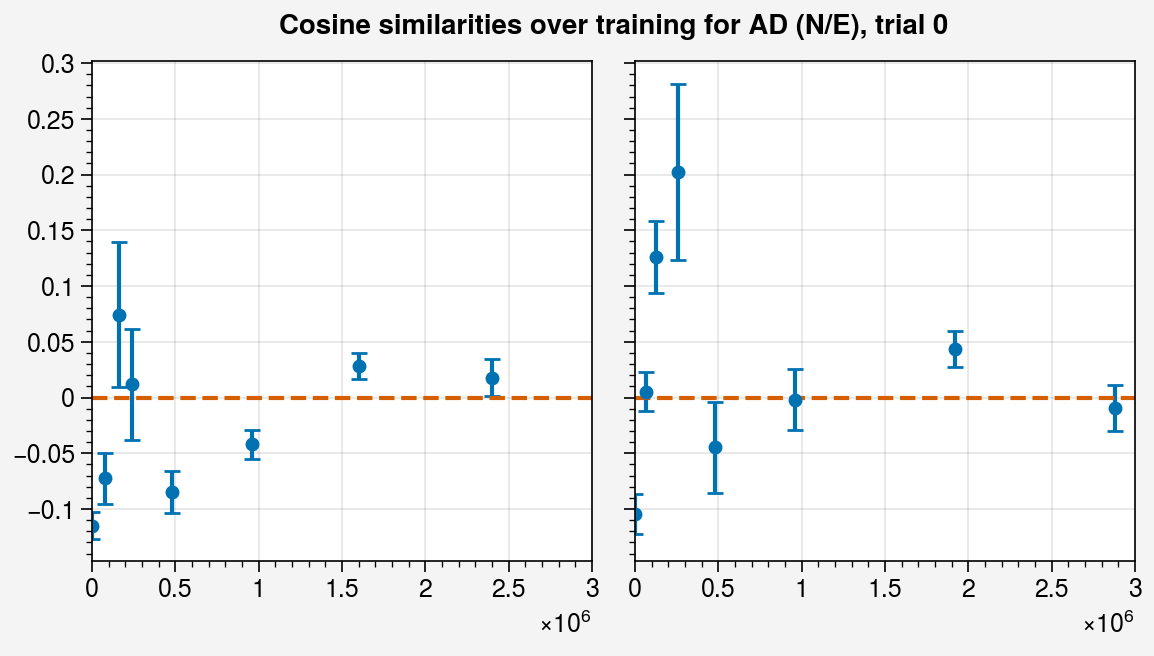

In [317]:
batch_sizes = [16, 32]
aux = 'wall01'
aux_label = 'AD (N/E)'
trial = 0

fig, ax = pplt.subplots(ncols=len(batch_sizes))

for i, batch in enumerate(batch_sizes):
    chks = all_chks[batch]
    
    xs = []
    means = []
    ci_highs = []
    ci_lows = []
    errors = []
    for chk in chks:
        cs = cs_means[batch][aux][trial][chk]
        mean = np.mean(cs)
        interval = stats.t.interval(alpha=0.95, df=len(cs)-1, 
                         loc=mean, scale=stats.sem(cs))
        
        xs.append(chk*batch*100)
        means.append(mean)
        ci_highs.append(interval[1])
        ci_lows.append(interval[0])
        errors.append(interval[1] - mean)
        
    cis = np.vstack([ci_lows, ci_highs])
    ax[i].errorbar(xs, means, errors, linestyle='', marker='o', markersize=4)
    ax[i].plot([0, 3e6], [0, 0], '--')
ax.format(suptitle=f'Cosine similarities over training for {aux_label}, trial {trial}')
    
    

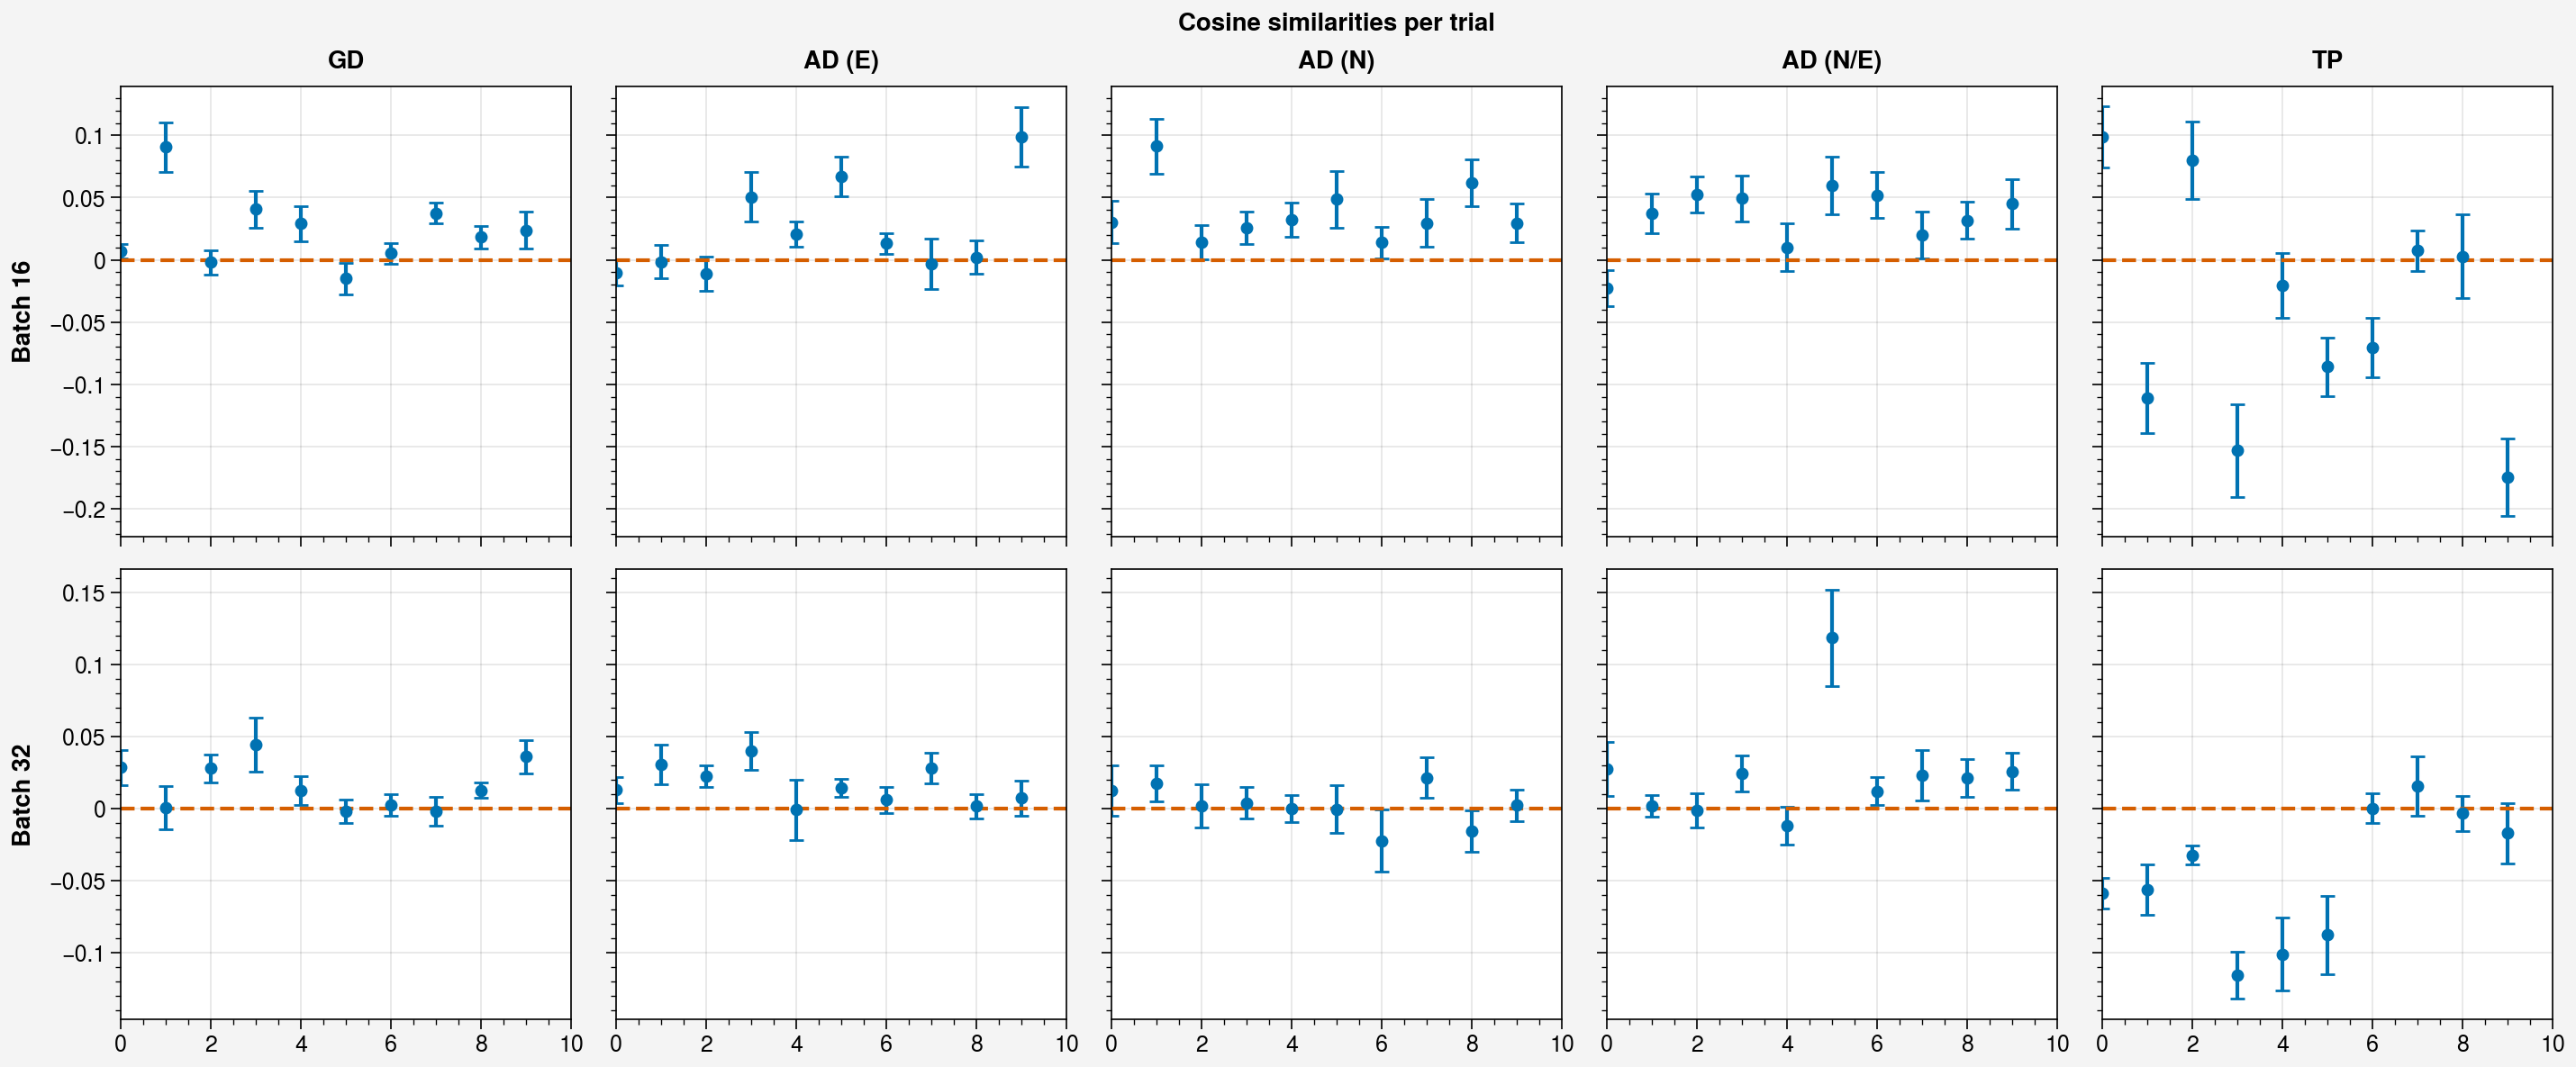

In [318]:
trials = range(10)

fig, ax = pplt.subplots(nrows=len(batch_sizes), ncols=len(aux_tasks))

for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        chks = all_chks[batch]

        
        xs = []
        trial_means = []
        errors = []
        for trial in trials:
            xs.append(trial)
            cos_sims = []
            for chk in chks:
                cs = cs_means[batch][aux][trial][chk]
                cos_sims.append(cs)
            cs = np.array(cos_sims).reshape(-1)
            mean = np.mean(cs)
            interval = stats.t.interval(alpha=0.95, df=len(cs)-1, 
                             loc=mean, scale=stats.sem(cs))
            
            errors.append(interval[1] - mean)
            trial_means.append(mean)

        ax[i, j].errorbar(xs, trial_means, errors, linestyle='',
                          marker='o', markersize=4)
    
ax.format(suptitle=f'Cosine similarities per trial',
          toplabels=aux_labels, leftlabels=[f'Batch {batch}' for batch in batch_sizes])
    
for i in range(len(batch_sizes)):
    for j in range(len(aux_tasks)):
        ax[i, j].plot([0, 10], [0, 0], '--')

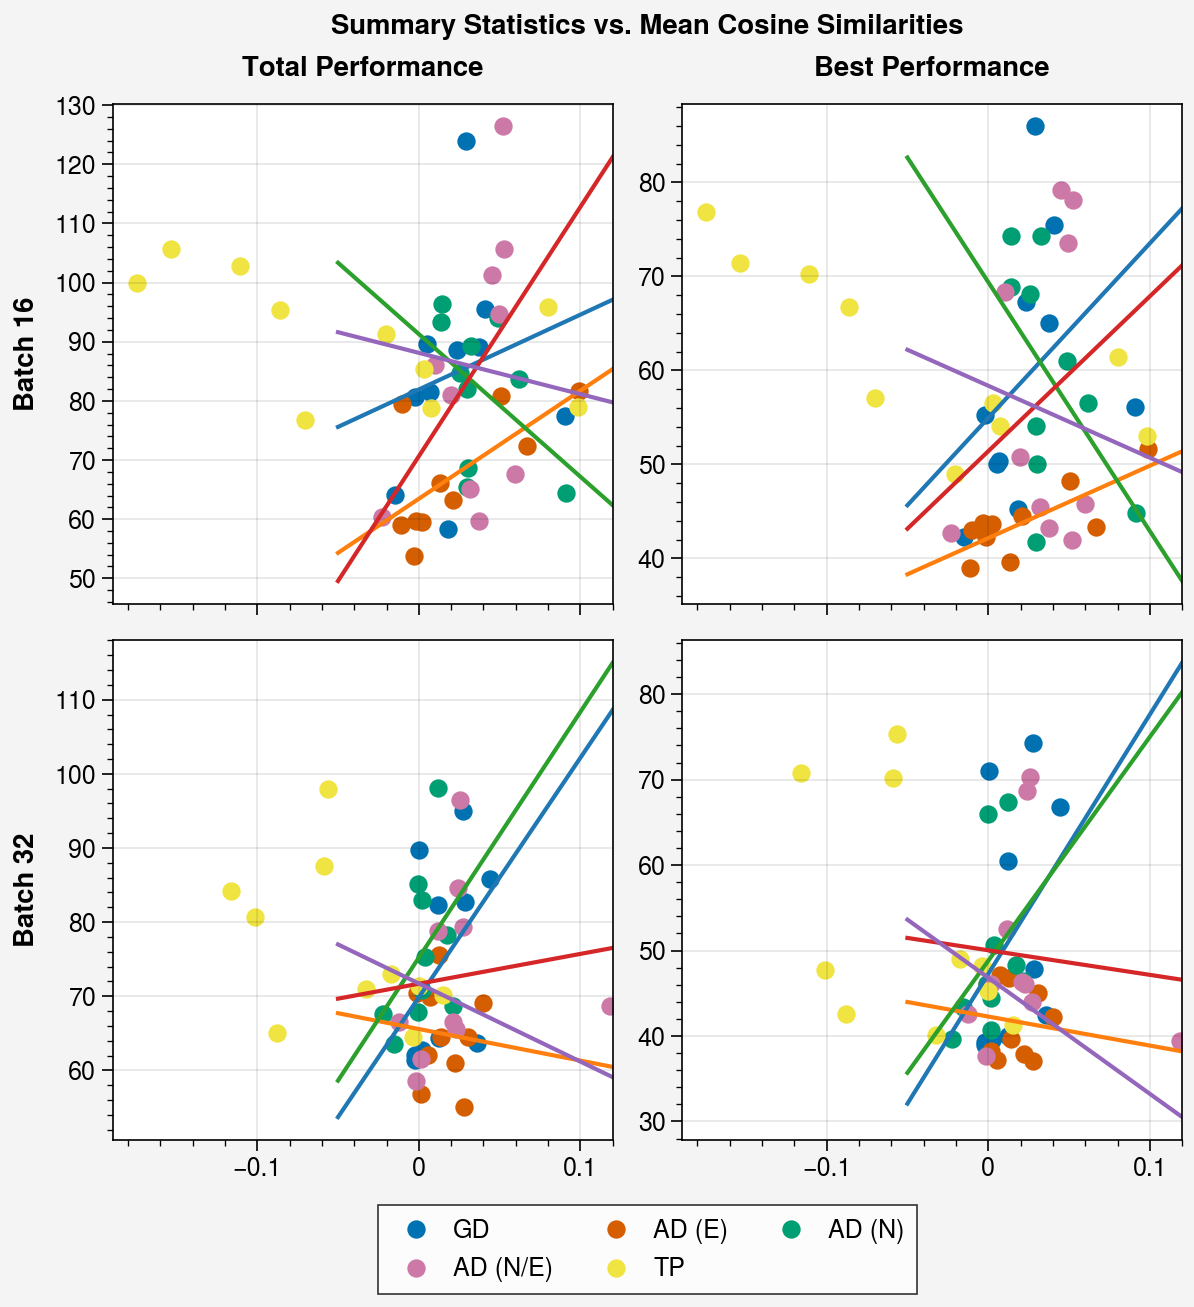

In [320]:
fig, ax = pplt.subplots(nrows=2, ncols=2, sharey=False)

for i, batch in enumerate(batch_sizes):
    scatters = []
    for j, aux in enumerate(aux_tasks):
        x = all_xs[f'batch{batch}aux{aux}']
        perf = total_perf[f'batch{batch}aux{aux}']
        best = best_perf[f'batch{batch}aux{aux}']
        
        scatters.append(ax[i, 0].scatter(x, perf, label=aux_labels[j]))
        ax[i, 1].scatter(x, best)
        
        #Add best fit lines
        xline = np.linspace(-0.05, 0.12, 3)
        z = np.polyfit(x, perf, 1)
        yline = xline*z[0] + z[1]
        ax[i, 0].plot(xline, yline, c=rgb_colors[j])

        xline = np.linspace(-0.05, 0.12, 3)
        z = np.polyfit(x, best, 1)
        yline = xline*z[0] + z[1]
        ax[i, 1].plot(xline, yline, c=rgb_colors[j])
        
        
                
ax.format(leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          toplabels=['Total Performance', 'Best Performance'],
          suptitle='Summary Statistics vs. Mean Cosine Similarities')
fig.legend(scatters, aux_labels, loc='b')


### Overall means

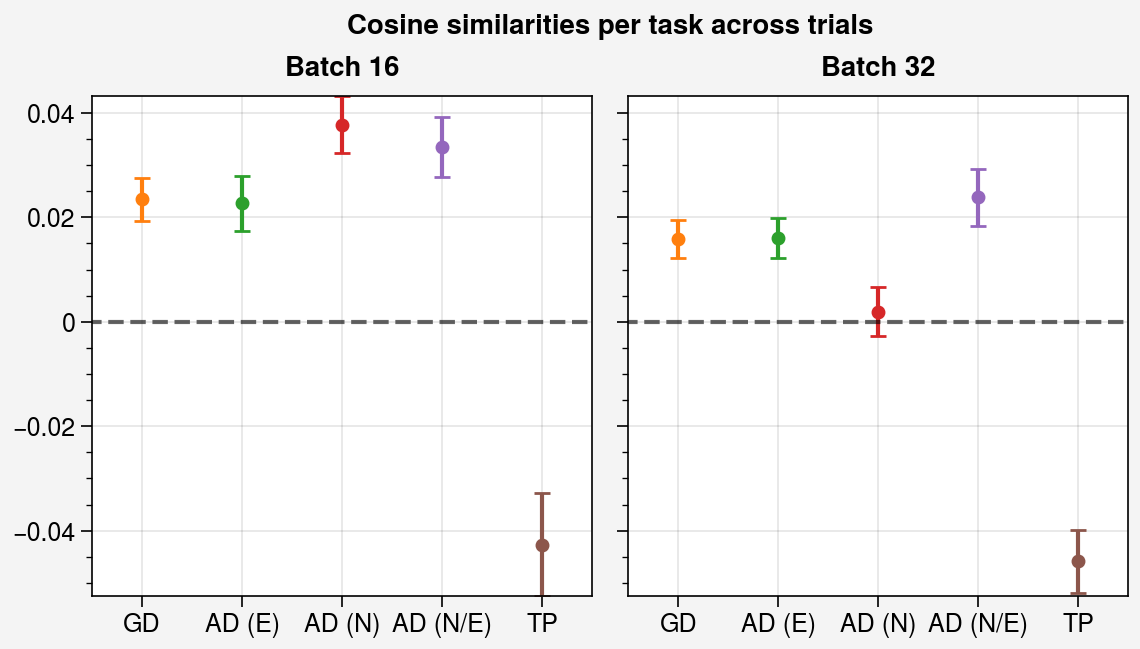

In [326]:
batch_sizes = [16, 32]
trials = range(10)

fig, ax = pplt.subplots(ncols=len(batch_sizes))

for i, batch in enumerate(batch_sizes):
    xs = []
    trial_means = []
    errors = []

    for j, aux in enumerate(aux_tasks):
        chks = all_chks[batch]
        xs.append(j)
        
        cos_sims = []
        for trial in trials:
            for chk in chks:
                cs = cs_means[batch][aux][trial][chk]
                cos_sims.append(cs)
        cs = np.array(cos_sims).reshape(-1)
        mean = np.mean(cs)
        interval = stats.t.interval(alpha=0.95, df=len(cs)-1, 
                         loc=mean, scale=stats.sem(cs))

        errors.append(interval[1] - mean)
        trial_means.append(mean)

    for j in range(len(xs)):
        ax[i].errorbar(xs[j], trial_means[j], errors[j], linestyle='',
                          marker='o', markersize=4, c=rgb_colors[j+1])
    
ax.format(suptitle=f'Cosine similarities per task across trials',
          toplabels=[f'Batch {batch}' for batch in batch_sizes],
          xticklabels=aux_labels, xlocator=range(5), xlim=[-0.5, 4.5])
    
for i in range(len(batch_sizes)):
    ax[i].plot([-1, 5], [0, 0], '--k', alpha=0.6)

## Categorical Tasks

In [ ]:
%%time
print('Loading all grads')
all_res = pickle.load(open(f'data/grads/auxcat_100grads', 'rb'))
print('Loading ref grads')
ref_res = pickle.load(open(f'data/grads/auxcat_100refgrads', 'rb'))

batch_sizes = [16, 32]
aux_tasks = ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
aux_labels = ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (E/N)']
auxiliary_truth_sizes = [[1], [1], [1, 1],  [1], [1]]
trials = range(10)
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}

#Generated combined RL grads (value + action + entropy) for small and ref batches\
print('Generating RL grads')
for batch in batch_sizes:
    for aux in tqdm(aux_tasks):
        for trial in trials:
            chks = all_chks[batch]
            
            for chk in chks:
                res = all_res[batch][aux][trial][chk]
                ref = ref_res[batch][aux][trial][chk]

                
                grads = ref['all_grads']
                #Compute combined RL gradient vectors
                comb_grad1 = [[] for i in range(len(grads['value']))]
                for layer in range(len(grads['value'])):
                    for n in range(len(grads['value'][layer])):
                        comb_grad1[layer].append(torch.zeros(grads['value'][layer][n].shape))

                for layer in range(len(grads['value'])):
                    for n in range(len(grads['value'][layer])):
                        for grad_type in ['action', 'value', 'entropy']:
                            comb_grad1[layer][n] += grads[grad_type][layer][n]
                        comb_grad1[layer][n] = comb_grad1[layer][n].clone()
                ref_res[batch][aux][trial][chk]['all_grads']['rl'] = comb_grad1


                grads = res['all_grads']
                #Compute combined RL gradient vectors
                comb_grad2 = [[] for i in range(len(grads['value']))]
                for layer in range(len(grads['value'])):
                    for n in range(len(grads['value'][layer])):
                        comb_grad2[layer].append(torch.zeros(grads['value'][layer][n].shape))

                for layer in range(len(grads['value'])):
                    for n in range(len(grads['value'][layer])):
                        for grad_type in ['action', 'value', 'entropy']:
                            comb_grad2[layer][n] += grads[grad_type][layer][n]
                        comb_grad2[layer][n] = comb_grad2[layer][n].clone()
                all_res[batch][aux][trial][chk]['all_grads']['rl'] = comb_grad2
                
                
#Compute gradients
print('Computing gradients')

'''Old method of selecting specific layers'''
# weight_layers = [0, 1, 4, 6] #final indexes of weight layers after selecting layer subset
# bias_layers = [2, 3, 5, 7] #final indexes of bias layers after selecting layer subset

# #after reindexing: layers 0, 1: RNN weights.  2, 3: RNN biases.  4, 6: actor 1/2 weights.  5, 7: actor 1/2 biases.

# #cosine similarities indexed by [batch][aux][trial][chk]

# cs_means = {}
# for batch in batch_sizes:
#     cs_means[batch] = {}
#     for aux in aux_tasks:
#         cs_means[batch][aux] = {}
#         for trial in trials:
#             cs_means[batch][aux][trial] = {}

# for batch in batch_sizes:
#     chks = all_chks[batch]
    
#     for aux in aux_tasks:
#         for trial in trials:
#             for chk in chks:
#                 ref_rl_grad = ref_res[batch][aux][trial][chk]['all_grads']['rl']
#                 aux_grad = all_res[batch][aux][trial][chk]['all_grads']['auxiliary']
                
#                 cs = cos_sim_grad(ref_rl_grad, aux_grad, use_layer_subset=[0, 1, 2, 3, 6, 7, 10, 11])
#                 cs_batch_means = [layer.mean(axis=0) for layer in cs]
#                 cs_means[batch][aux][trial][chk] = cs_batch_means
         
    
#Alternate method to compute cosine similarity by concatenating 
# all grad layers together before performing cosine similarity
# which in fact seems like a less arbitrary choice and maybe more natural
cs_means = {}
for batch in batch_sizes:
    cs_means[batch] = {}
    for aux in aux_tasks:
        cs_means[batch][aux] = {}
        for trial in trials:
            cs_means[batch][aux][trial] = {}


for batch in batch_sizes:
    chks = all_chks[batch]
    
    for aux in aux_tasks:
        for trial in trials:
            for chk in chks:
                ref_rl_grad = ref_res[batch][aux][trial][chk]['all_grads']['rl']
                aux_grad = all_res[batch][aux][trial][chk]['all_grads']['auxiliary']
                
                layers = range(len(ref_rl_grad))
                # Concatenate ref RL grads
                num_batches = len(ref_rl_grad[0])
                ref_gs = []
                for b in range(num_batches):
                    ref_g = [ref_rl_grad[layer][b].reshape(-1) for layer in layers]
                    ref_gs.append(torch.concat(ref_g))
                ref_gs = torch.vstack(ref_gs)

                # Concatenate aux grads
                num_batches = len(aux_grad[0])
                gs = []
                for b in range(num_batches):
                    g = [aux_grad[layer][b].reshape(-1) for layer in layers]
                    gs.append(torch.concat(g))
                gs = torch.vstack(gs)
                
                # Batch/ref batch pairwise similarity, 
                # averaged per batch (averaging 3 similarities)
                cs = cosine_similarity(ref_gs, gs).mean(axis=0)
                cs_means[batch][aux][trial][chk] = cs
                
pickle.dump(cs_means, open('data/grads/auxcat_100cs', 'wb'))

Loading all grads
Loading ref grads
Generating RL grads


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


Computing gradients
CPU times: total: 54 s
Wall time: 1min 16s


In [ ]:
'''Load computed cosine similarities instead of running calculations'''
cs_means = pickle.load(open('data/grads/auxcat_100cs', 'rb'))

batch_sizes = [16, 32]
aux_tasks = ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
aux_labels = ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (E/N)']
auxiliary_truth_sizes = [[1], [1], [1, 1],  [1], [1]]
trials = range(10)
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}

best_perf = defaultdict(list)
total_perf = defaultdict(list)
all_xs = defaultdict(list)

for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        exp_name = f'nav_pdistal_auxcatcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
        xs, ys, min_x, max_x = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001, ret=True)
        y_ints = (ys[:, 100:] * np.diff(xs[99:])).sum(axis=1) / (xs[-1] - xs[99])
        
        best_perf[f'batch{batch}aux{aux}'] = ys[:, 100:].min(axis=1)
        total_perf[f'batch{batch}aux{aux}'] = y_ints
        
        chks = all_chks[batch]
        for trial in trials:
            mean_cs = np.stack(list(cs_means[batch][aux][trial].values())).mean()
            all_xs[f'batch{batch}aux{aux}'].append(mean_cs)

### Check whether there is difference in computing cs layer-wise and averaging vs computing cs across all layers simultaneously

Turns out there is a significant difference in how we calculate similarity (layer first or concatenate all)

It looks like maybe concatenation gives higher similarity values?

In [ ]:
# layers = [0, 1, 2, 3, 6, 7, 10, 11]
layers = range(18)
num_batches = len(ref_rl_grad[0])
ref_gs = []

for batch in range(num_batches):
    ref_g = [ref_rl_grad[layer][batch].reshape(-1) for layer in layers]
    ref_gs.append(torch.concat(ref_g))
    
ref_gs = torch.vstack(ref_gs)



num_batches = len(aux_grad[0])
gs = []

for batch in range(num_batches):
    g = [aux_grad[layer][batch].reshape(-1) for layer in layers]
    gs.append(torch.concat(g))
    
gs = torch.vstack(gs)




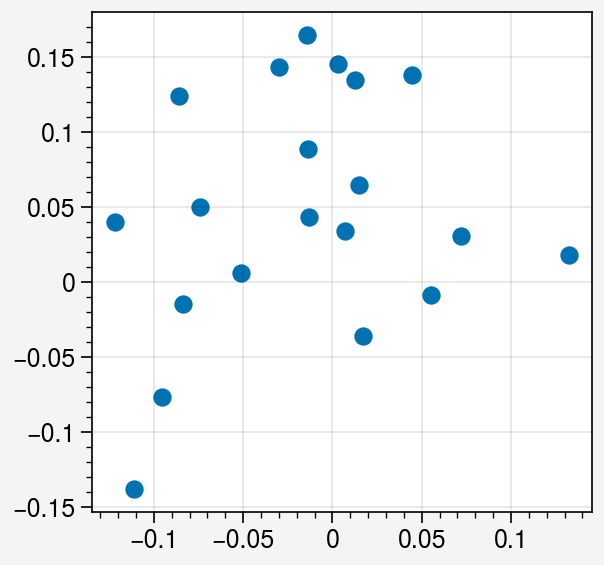

In [ ]:
fig, ax = pplt.subplots()
ax.scatter(cs, cs2)

### CS over training, 95% CIs

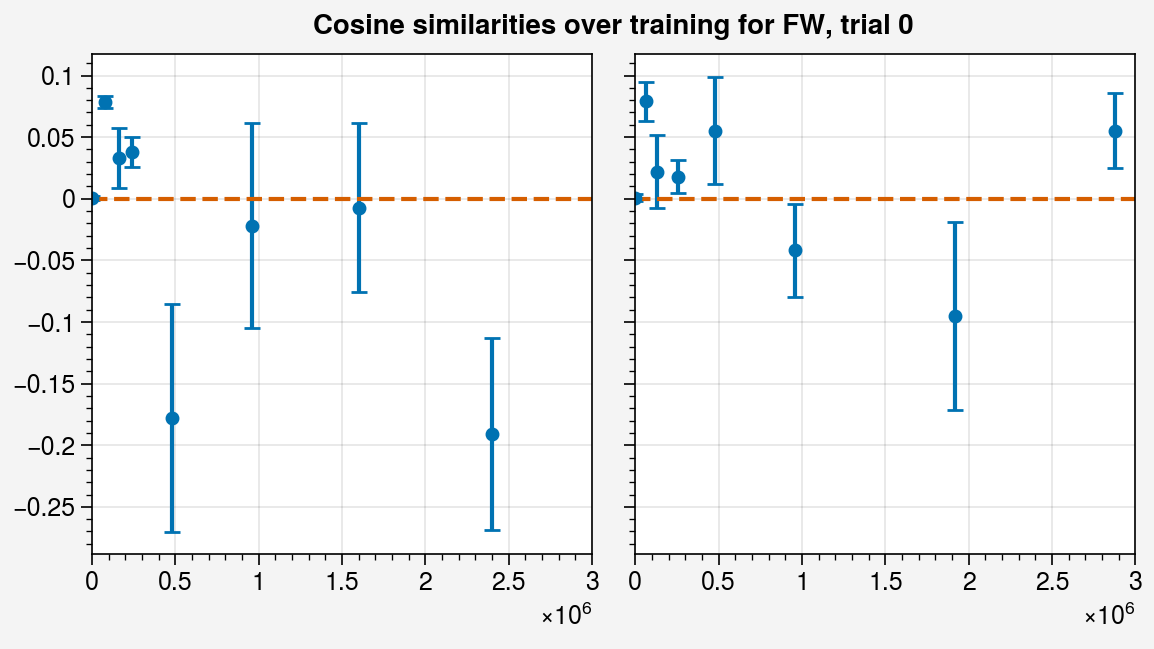

In [ ]:
batch_sizes = [16, 32]
aux = 'catfacewall'
aux_label = 'FW'
trial = 0

fig, ax = pplt.subplots(ncols=len(batch_sizes))

for i, batch in enumerate(batch_sizes):
    chks = all_chks[batch]
    
    xs = []
    means = []
    ci_highs = []
    ci_lows = []
    errors = []
    for chk in chks:
        cs = cs_means[batch][aux][trial][chk]
        mean = np.mean(cs)
        interval = stats.t.interval(alpha=0.95, df=len(cs)-1, 
                         loc=mean, scale=stats.sem(cs))
        
        xs.append(chk*batch*100)
        means.append(mean)
        ci_highs.append(interval[1])
        ci_lows.append(interval[0])
        errors.append(interval[1] - mean)
        
    cis = np.vstack([ci_lows, ci_highs])
    ax[i].errorbar(xs, means, errors, linestyle='', marker='o', markersize=4)
    ax[i].plot([0, 3e6], [0, 0], '--')
ax.format(suptitle=f'Cosine similarities over training for {aux_label}, trial {trial}')
    
    

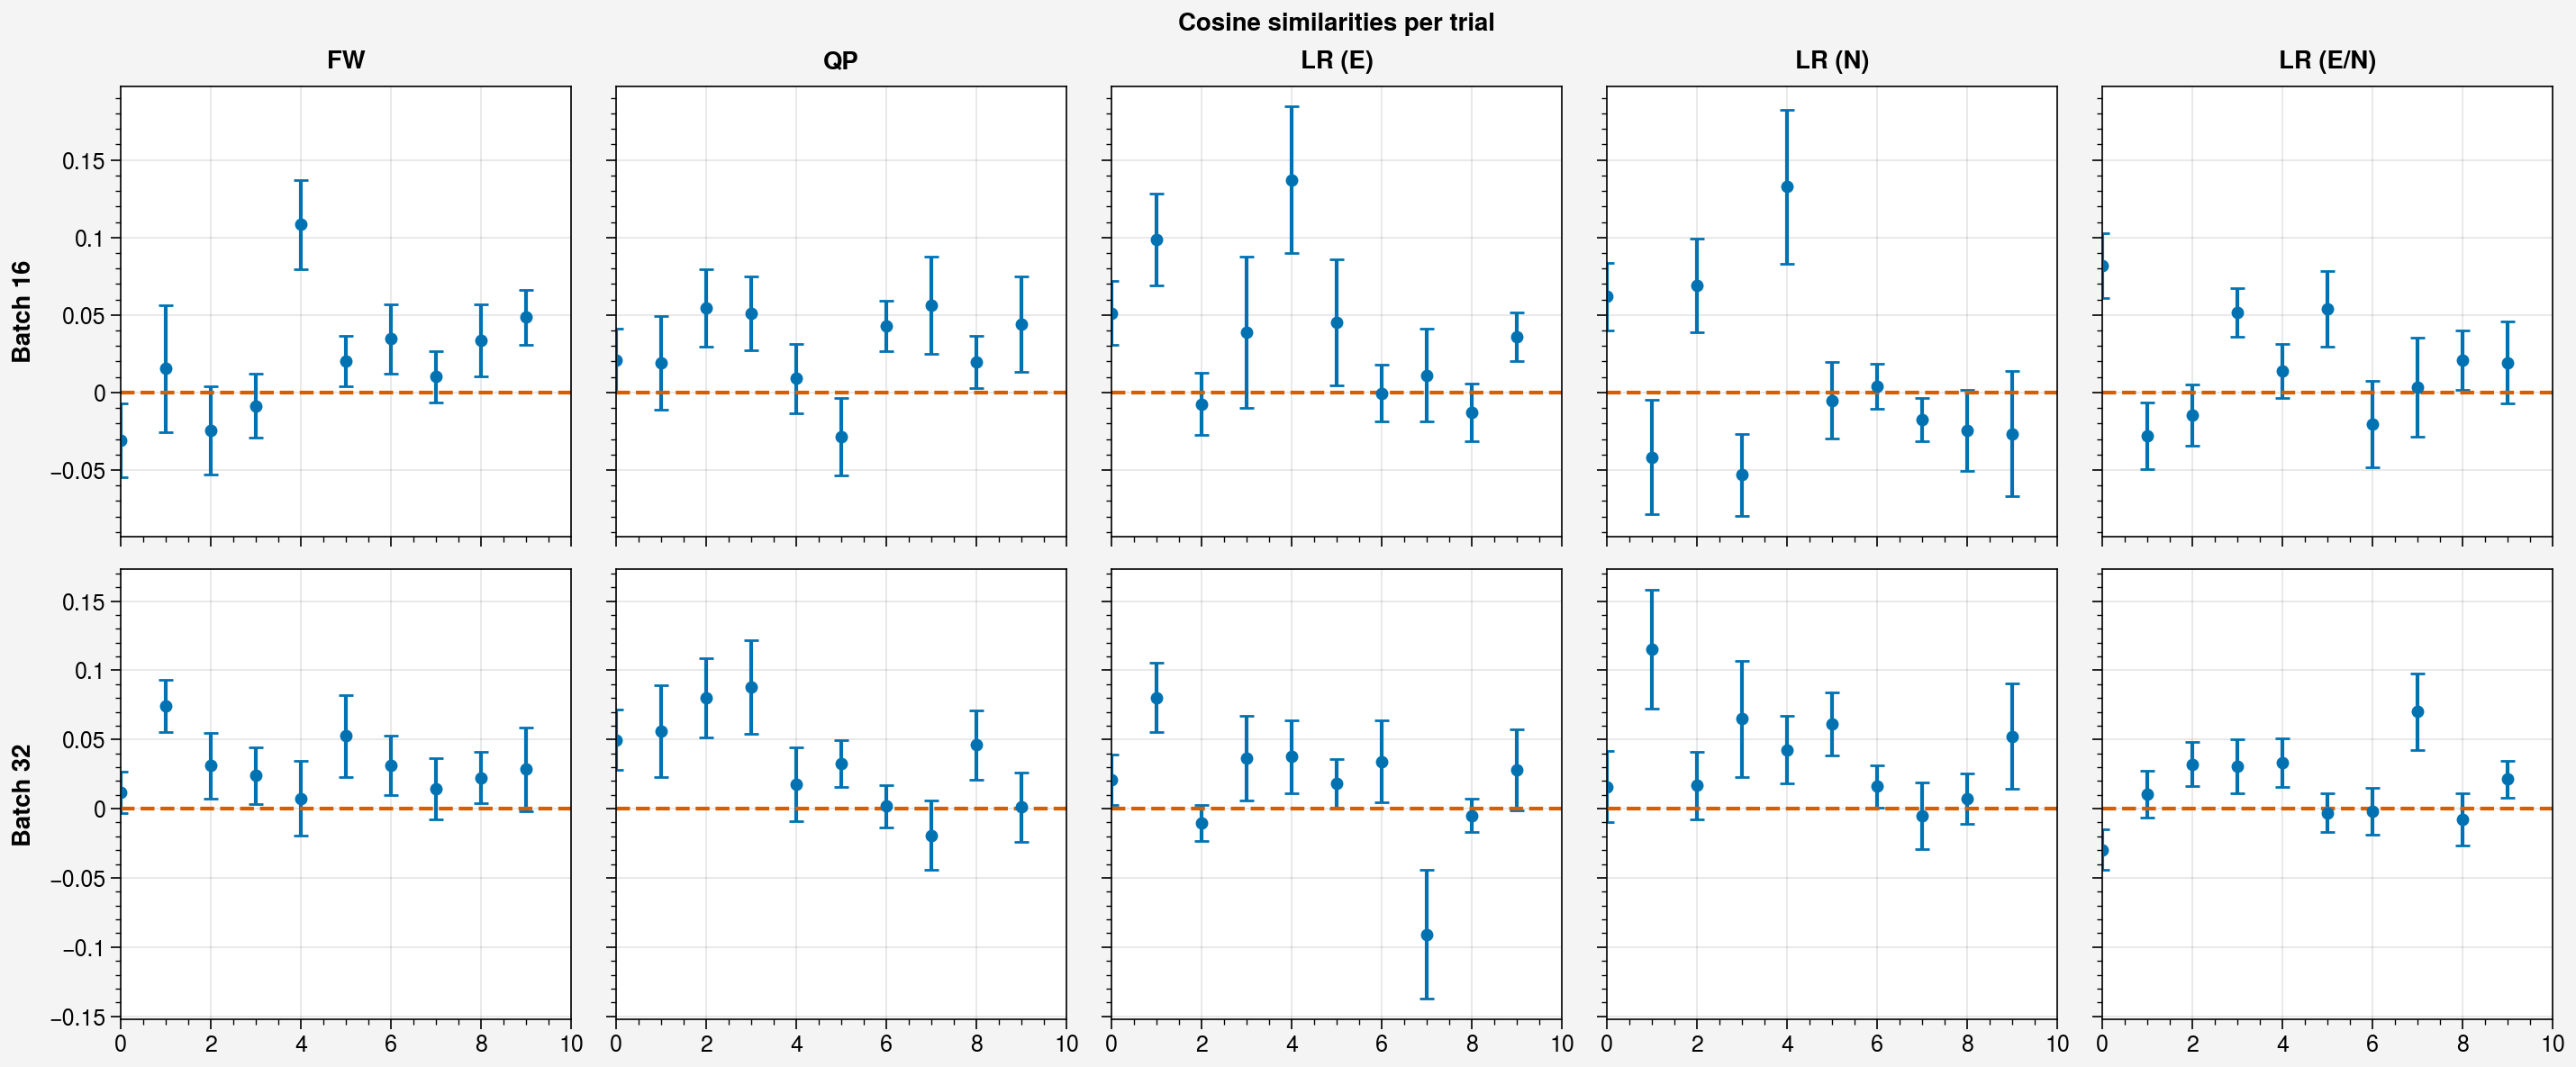

In [ ]:
batch_sizes = [16, 32]
aux_tasks = ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
aux_labels = ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (E/N)']
trials = range(10)

fig, ax = pplt.subplots(nrows=len(batch_sizes), ncols=len(aux_tasks))

for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        chks = all_chks[batch]

        
        xs = []
        trial_means = []
        errors = []
        for trial in trials:
            xs.append(trial)
            cos_sims = []
            for chk in chks:
                cs = cs_means[batch][aux][trial][chk]
                cos_sims.append(cs)
            cs = np.array(cos_sims).reshape(-1)
            mean = np.mean(cs)
            interval = stats.t.interval(alpha=0.95, df=len(cs)-1, 
                             loc=mean, scale=stats.sem(cs))
            
            errors.append(interval[1] - mean)
            trial_means.append(mean)

        ax[i, j].errorbar(xs, trial_means, errors, linestyle='',
                          marker='o', markersize=4)
    
ax.format(suptitle=f'Cosine similarities per trial',
          toplabels=aux_labels, leftlabels=[f'Batch {batch}' for batch in batch_sizes])
    
for i in range(len(batch_sizes)):
    for j in range(len(aux_tasks)):
        ax[i, j].plot([0, 10], [0, 0], '--')

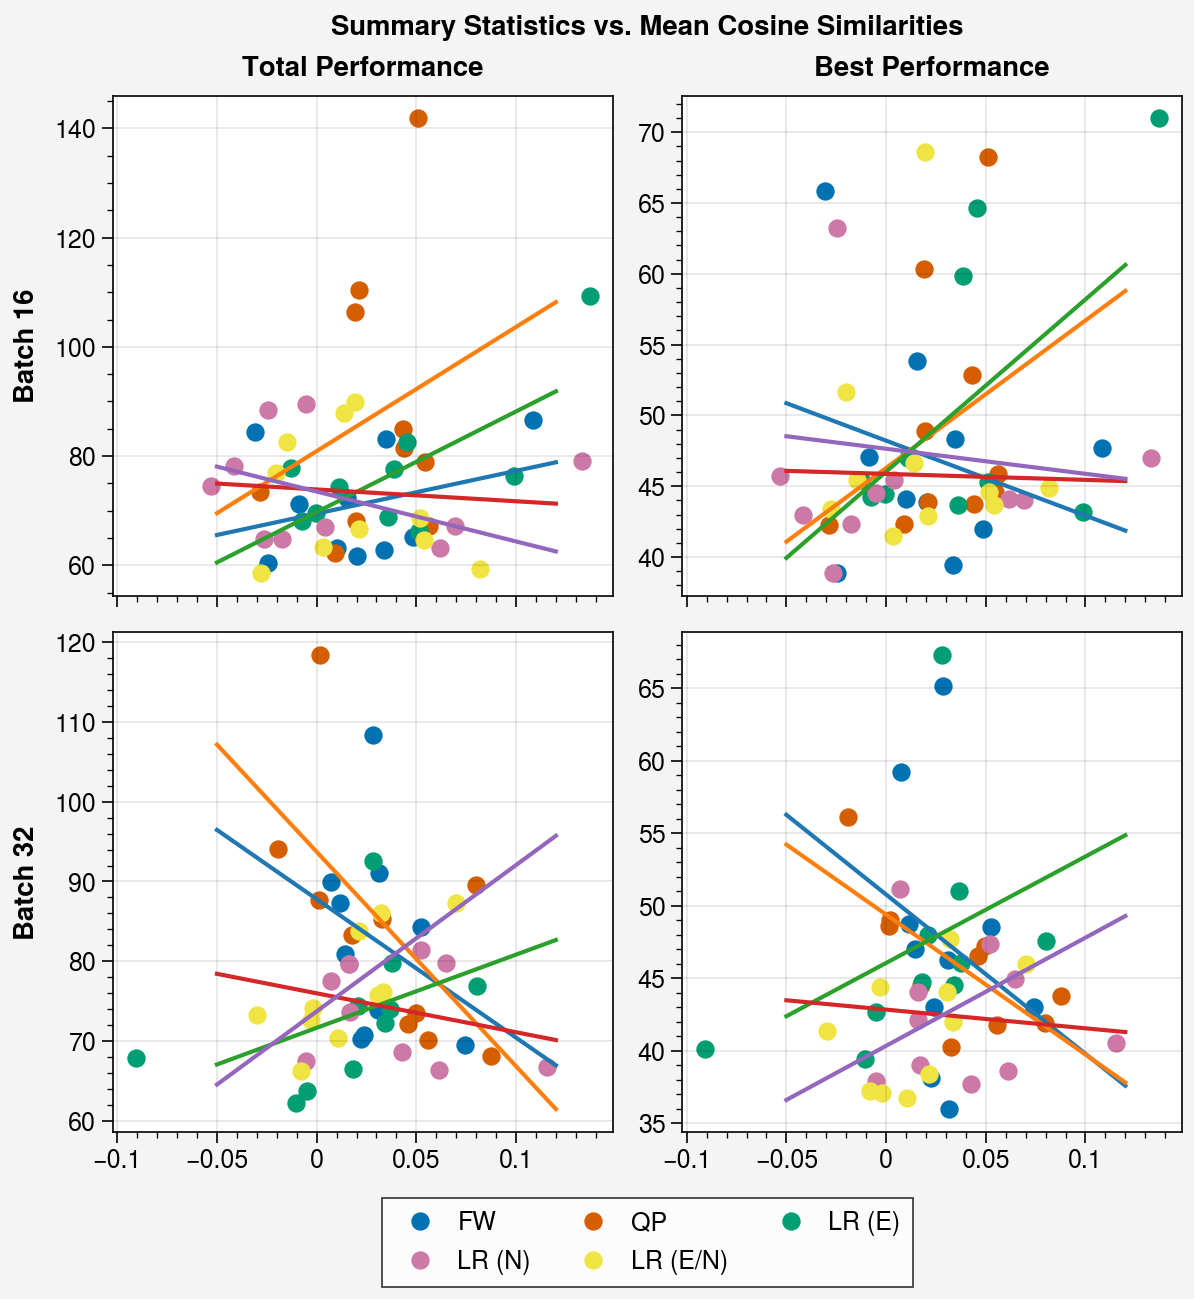

In [ ]:
fig, ax = pplt.subplots(nrows=2, ncols=2, sharey=False)

for i, batch in enumerate(batch_sizes):
    scatters = []
    for j, aux in enumerate(aux_tasks):
        x = all_xs[f'batch{batch}aux{aux}']
        perf = total_perf[f'batch{batch}aux{aux}']
        best = best_perf[f'batch{batch}aux{aux}']
        
        scatters.append(ax[i, 0].scatter(x, perf, label=aux_labels[j]))
        ax[i, 1].scatter(x, best)
        
        #Add best fit lines
        xline = np.linspace(-0.05, 0.12, 3)
        z = np.polyfit(x, perf, 1)
        yline = xline*z[0] + z[1]
        ax[i, 0].plot(xline, yline, c=rgb_colors[j])

        xline = np.linspace(-0.05, 0.12, 3)
        z = np.polyfit(x, best, 1)
        yline = xline*z[0] + z[1]
        ax[i, 1].plot(xline, yline, c=rgb_colors[j])
        
        
                
ax.format(leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          toplabels=['Total Performance', 'Best Performance'],
          suptitle='Summary Statistics vs. Mean Cosine Similarities')
fig.legend(scatters, aux_labels, loc='b')


### Overall means

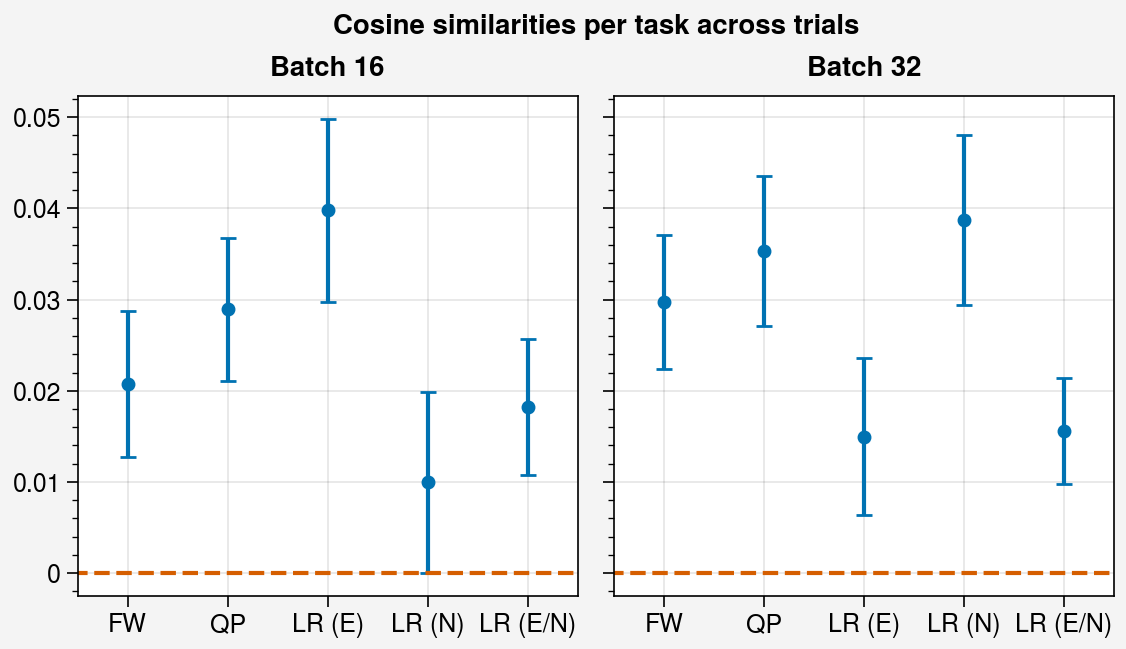

In [ ]:
batch_sizes = [16, 32]
aux_tasks = ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
aux_labels = ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (E/N)']
trials = range(10)

fig, ax = pplt.subplots(ncols=len(batch_sizes))

for i, batch in enumerate(batch_sizes):
    xs = []
    trial_means = []
    errors = []

    for j, aux in enumerate(aux_tasks):
        chks = all_chks[batch]
        xs.append(j)
        
        cos_sims = []
        for trial in trials:
            for chk in chks:
                cs = cs_means[batch][aux][trial][chk]
                cos_sims.append(cs)
        cs = np.array(cos_sims).reshape(-1)
        mean = np.mean(cs)
        interval = stats.t.interval(alpha=0.95, df=len(cs)-1, 
                         loc=mean, scale=stats.sem(cs))

        errors.append(interval[1] - mean)
        trial_means.append(mean)

    ax[i].errorbar(xs, trial_means, errors, linestyle='',
                      marker='o', markersize=4)
    
ax.format(suptitle=f'Cosine similarities per task across trials',
          toplabels=[f'Batch {batch}' for batch in batch_sizes],
          xticklabels=aux_labels, xlocator=range(5), xlim=[-0.5, 4.5])
    
for i in range(len(batch_sizes)):
    ax[i].plot([-1, 5], [0, 0], '--')

# Reward Auxiliary Tasks

## Combining RE with RD scaled

In [332]:
batch_sizes = [16, 32]
aux_tasks = ['rewdistscale0015', 'rewexplore']
aux_labels = ['RD', 'RE']
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}

# all_res = pickle.load(open('data/grads/auxrew_100grads', 'rb'))
# all_res2 = pickle.load(open('data/grads/auxrew_100grads_scale', 'rb'))

summary = pickle.load(open('data/grads/rew_aux_cs_summary', 'rb'))

In [365]:
'''Convert grad data from all_res and all_res2 to summary cosine similarity data'''

batch_sizes = [16, 32]
trials = range(3)

aux_tasks = ['rewdistscale0015', 'rewexplore', 'rewdist']
aux_labels = ['RD', 'RE', 'RD (Large Scale)']

all_cs = {}
all_xs = {}
all_cs_comb = {}
all_rew = {}

for i, batch in enumerate(tqdm(batch_sizes)):
    if batch not in all_cs: all_cs[batch] = {}
    for j, aux in enumerate(aux_tasks):
        if aux not in all_cs[batch]: all_cs[batch][aux] = {}
        
        xs = []
        cs_comb = []
        rews = []

        for trial in trials:
            if trial not in all_cs[batch][aux]:
                all_cs[batch][aux][trial] = {}

            if aux == 'rewdistscale0015':
                chk_res = all_res2[batch][aux][trial]
            else:
                chk_res = all_res[batch][aux][trial]
            chks = all_chks[batch]

            for _, chk in enumerate(chks):
                res = chk_res[chk]

                layers = range(len(res['all_grads_bonus']))
                num_batches = len(res['all_grads_bonus'][0])

                # Concatenate full RL grad
                full_grads = []
                for b in range(num_batches):
                    g = [res['all_grads_pure_bonus'][layer][b].reshape(-1) for layer in layers]
                    full_grads.append(torch.concat(g))
                full_grads = torch.vstack(full_grads)

                # Concatenate pure bonus grad
                bonus_grads = []
                for b in range(num_batches):
                    g = [res['all_grads_bonus'][layer][b].reshape(-1) for layer in layers]
                    bonus_grads.append(torch.concat(g))
                bonus_grads = torch.vstack(bonus_grads)

                # Compute cosine similarities
                cs = []
                for b in range(num_batches):
                    cs.append(cosine_similarity(bonus_grads[b].reshape(1, -1),
                                                full_grads[b].reshape(1, -1)).item())

                all_cs[batch][aux][trial][chk] = cs                
                xs += [chk] * num_batches
                cs_comb += cs
                # rews += res['rewards']
                
                rew = []
                for r in res['all_rewards_bonus']:
                    rew.append(len(r[r >= 3]))
                rews += rew
                
        
        all_xs[f'batch{batch}aux{aux}'] = xs
        all_cs_comb[f'batch{batch}aux{aux}'] = cs_comb
        all_rew[f'batch{batch}aux{aux}'] = rews

summary = {
    'xs': all_xs,
    'cs_comb': all_cs_comb,
    'rews': all_rew,
    'cs': all_cs
}

pickle.dump(summary, open('data/grads/rew_aux_cs_summary', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


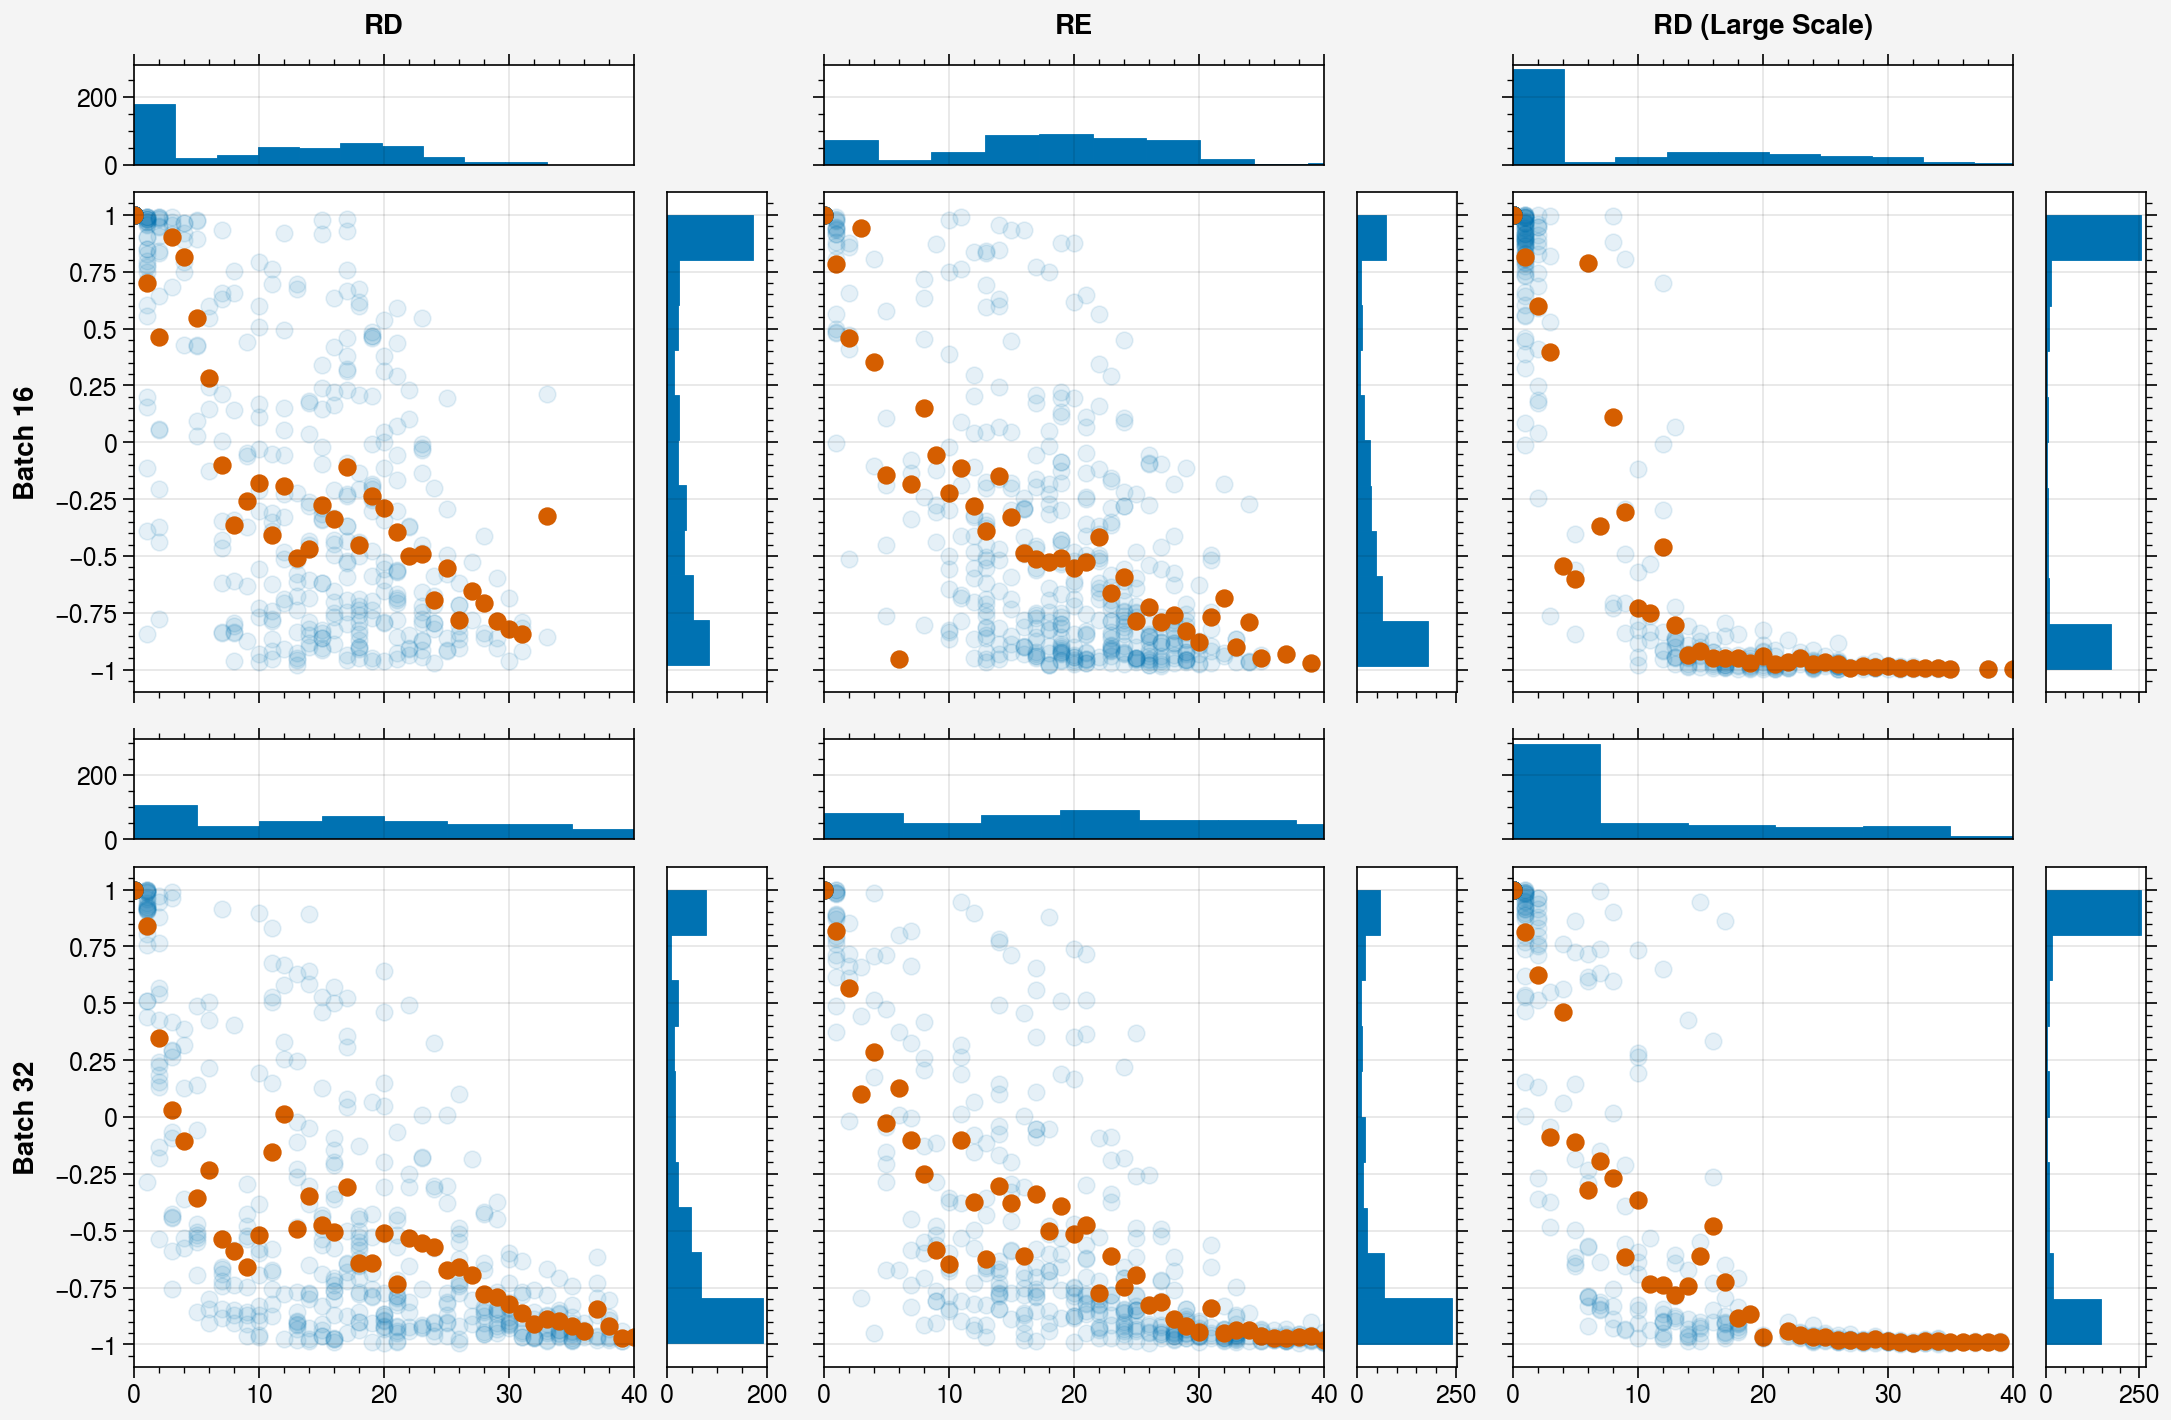

In [342]:
summary = pickle.load(open('data/grads/rew_aux_cs_summary', 'rb'))
all_cs_comb = summary['cs_comb']
all_rew = summary['rews']

aux_tasks = ['rewdistscale0015', 'rewexplore', 'rewdist']
aux_labels = ['RD', 'RE', 'RD (Large Scale)']

fig, ax = pplt.subplots(nrows=2, ncols=3)

tax = ax.panel_axes('top')
rax = ax.panel_axes('right')

for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        
        cs = np.array(all_cs_comb[f'batch{batch}aux{aux}'])
        rews = np.array(all_rew[f'batch{batch}aux{aux}'])

        x_means = []
        y_means = []
        for r in np.unique(rews):
            x_means.append(r)
            y_means.append(cs[rews == r].mean())
        
        ax[i, j].scatter(all_rew[f'batch{batch}aux{aux}'], all_cs_comb[f'batch{batch}aux{aux}'], alpha=0.1)
        ax[i, j].scatter(x_means, y_means)
        
        tax[i, j].hist(rews)
        rax[i, j].histh(cs)
ax.format(toplabels=aux_labels, leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          xlim=[0, 40])

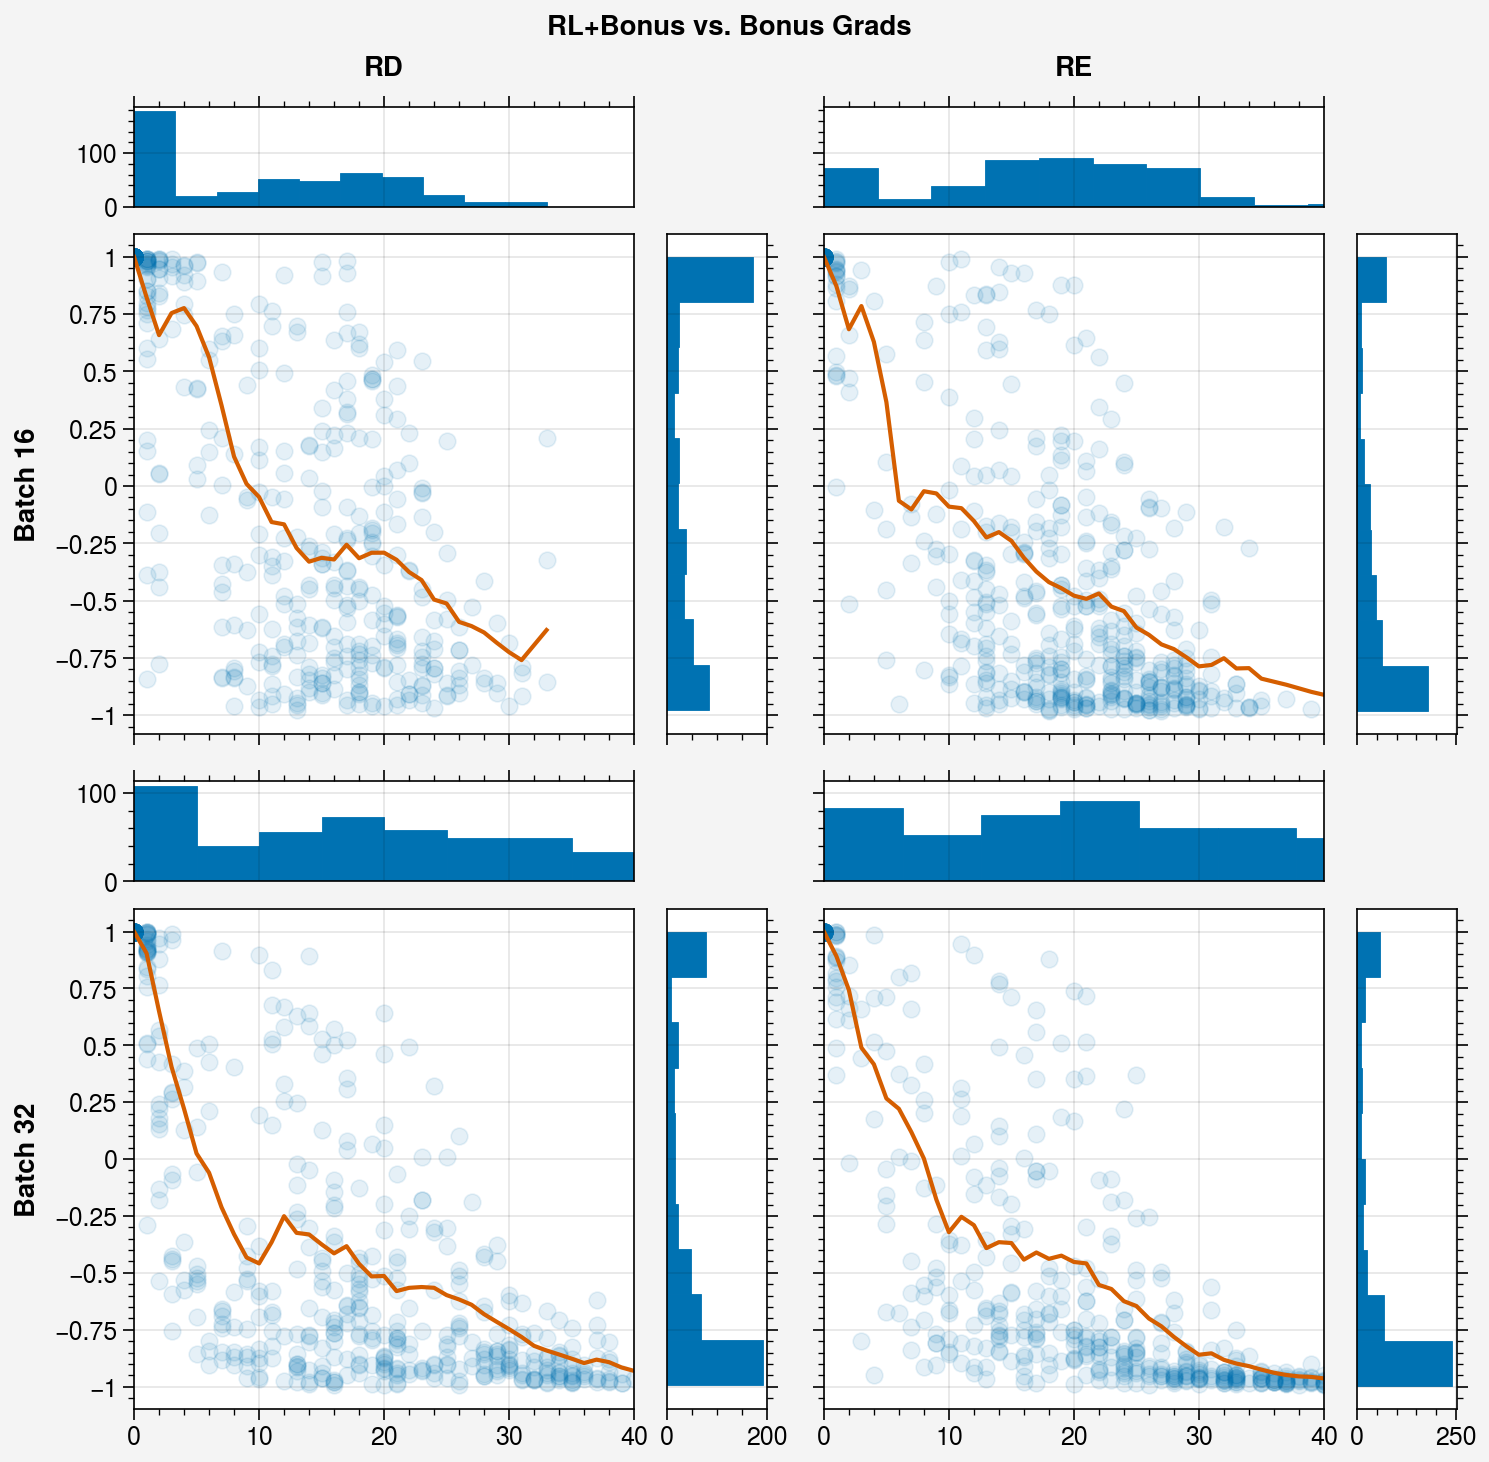

In [372]:
summary = pickle.load(open('data/grads/rew_aux_cs_summary', 'rb'))
all_cs_comb = summary['cs_comb']
all_rew = summary['rews']

aux_tasks = ['rewdistscale0015', 'rewexplore',]
aux_labels = ['RD', 'RE',]

fig, ax = pplt.subplots(nrows=2, ncols=2)

tax = ax.panel_axes('top')
rax = ax.panel_axes('right')

for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        
        cs = np.array(all_cs_comb[f'batch{batch}aux{aux}'])
        rews = np.array(all_rew[f'batch{batch}aux{aux}'])

        x_means = []
        y_means = []
        for r in np.unique(rews):
            x_means.append(r)
            y_means.append(cs[rews == r].mean())
        running_y_mean = pd.Series(y_means).ewm(alpha=0.3).mean()
        
        ax[i, j].scatter(all_rew[f'batch{batch}aux{aux}'], all_cs_comb[f'batch{batch}aux{aux}'], alpha=0.1)
        ax[i, j].plot(x_means, running_y_mean)
        
        tax[i, j].hist(rews)
        rax[i, j].histh(cs)
ax.format(toplabels=aux_labels, leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          xlim=[0, 40], suptitle='RL+Bonus vs. Bonus Grads')

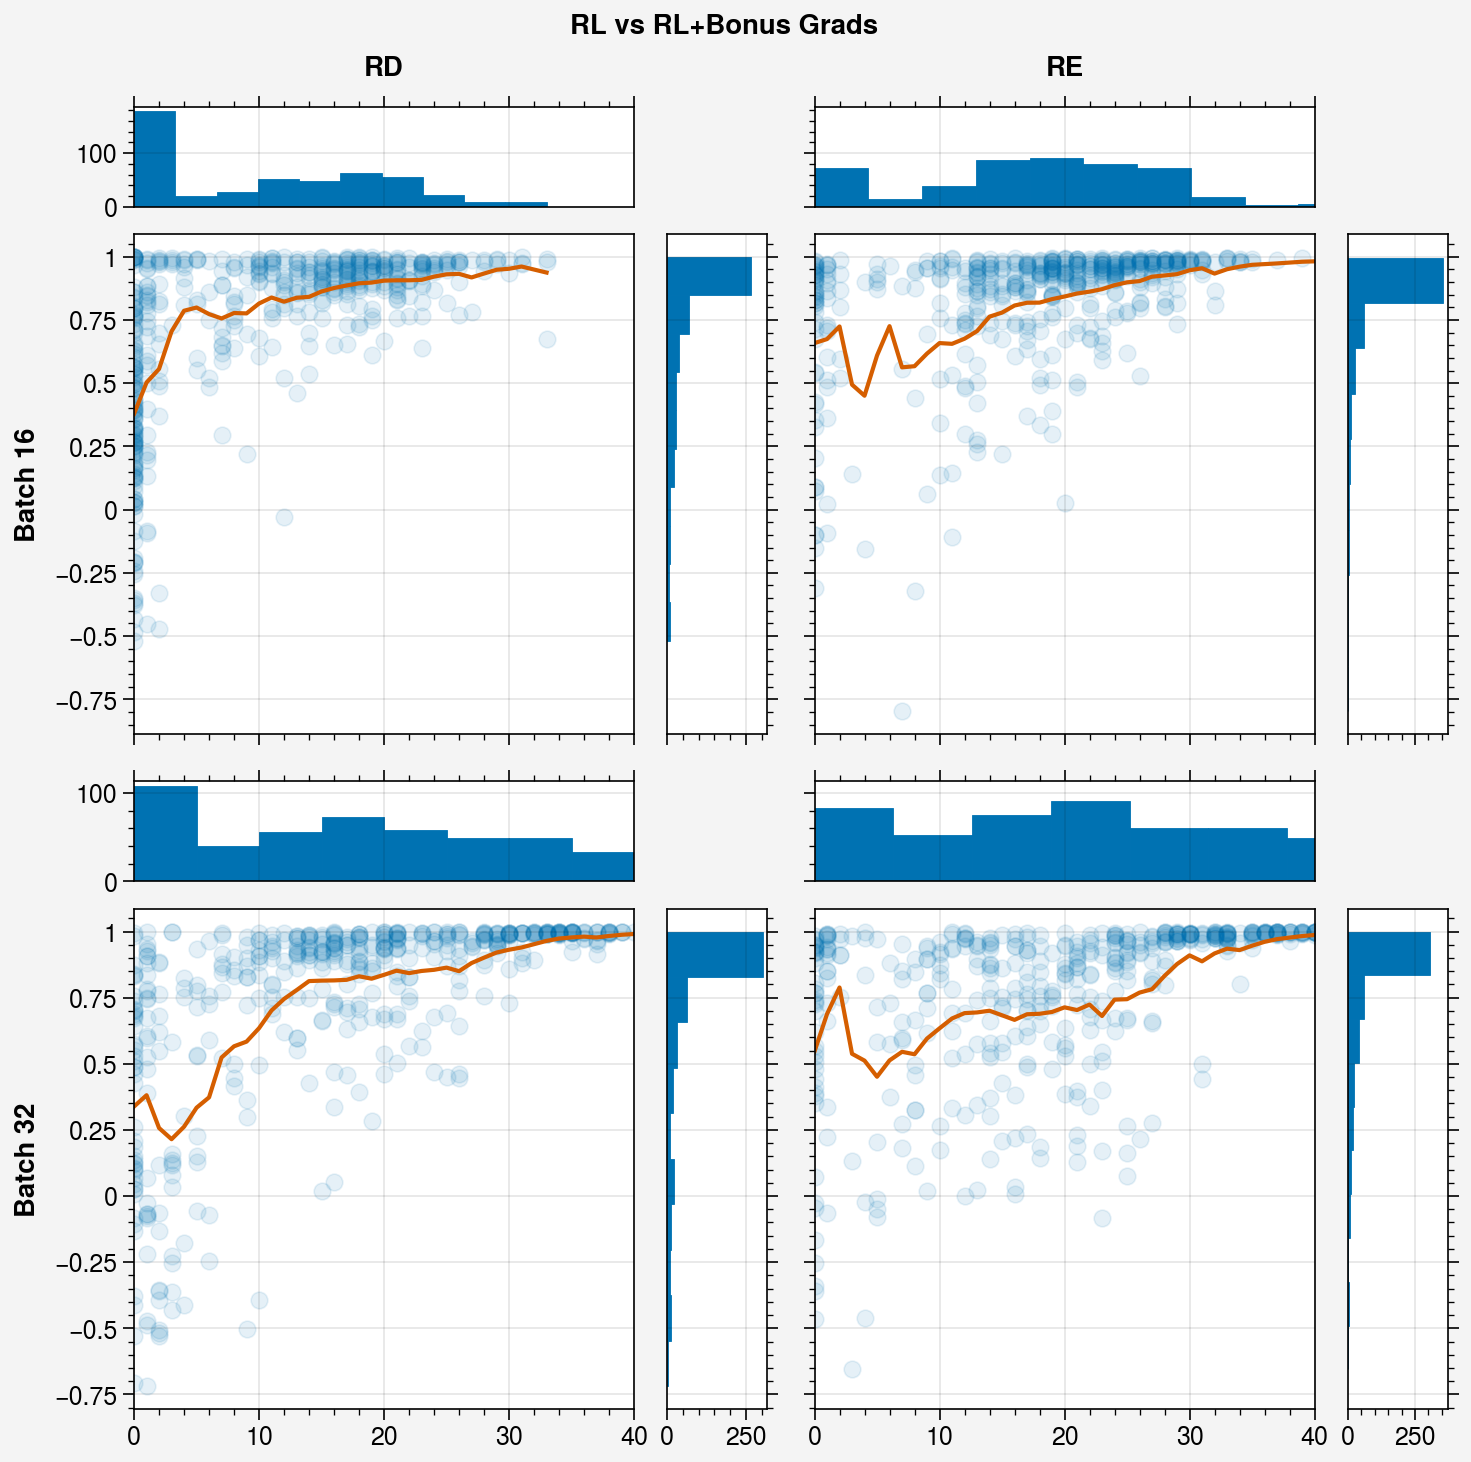

In [373]:
summary = pickle.load(open('data/grads/rew_aux_cs_summary_rlvsboth', 'rb'))
all_cs_comb = summary['cs_comb']
all_rew = summary['rews']

aux_tasks = ['rewdistscale0015', 'rewexplore',]
aux_labels = ['RD', 'RE',]

fig, ax = pplt.subplots(nrows=2, ncols=2)

tax = ax.panel_axes('top')
rax = ax.panel_axes('right')

for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        
        cs = np.array(all_cs_comb[f'batch{batch}aux{aux}'])
        rews = np.array(all_rew[f'batch{batch}aux{aux}'])

        x_means = []
        y_means = []
        for r in np.unique(rews):
            x_means.append(r)
            y_means.append(cs[rews == r].mean())
        running_y_mean = pd.Series(y_means).ewm(alpha=0.3).mean()
        
        ax[i, j].scatter(all_rew[f'batch{batch}aux{aux}'], all_cs_comb[f'batch{batch}aux{aux}'], alpha=0.1)
        ax[i, j].plot(x_means, running_y_mean)
        
        tax[i, j].hist(rews)
        rax[i, j].histh(cs)
ax.format(toplabels=aux_labels, leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          xlim=[0, 40], suptitle='RL vs RL+Bonus Grads')

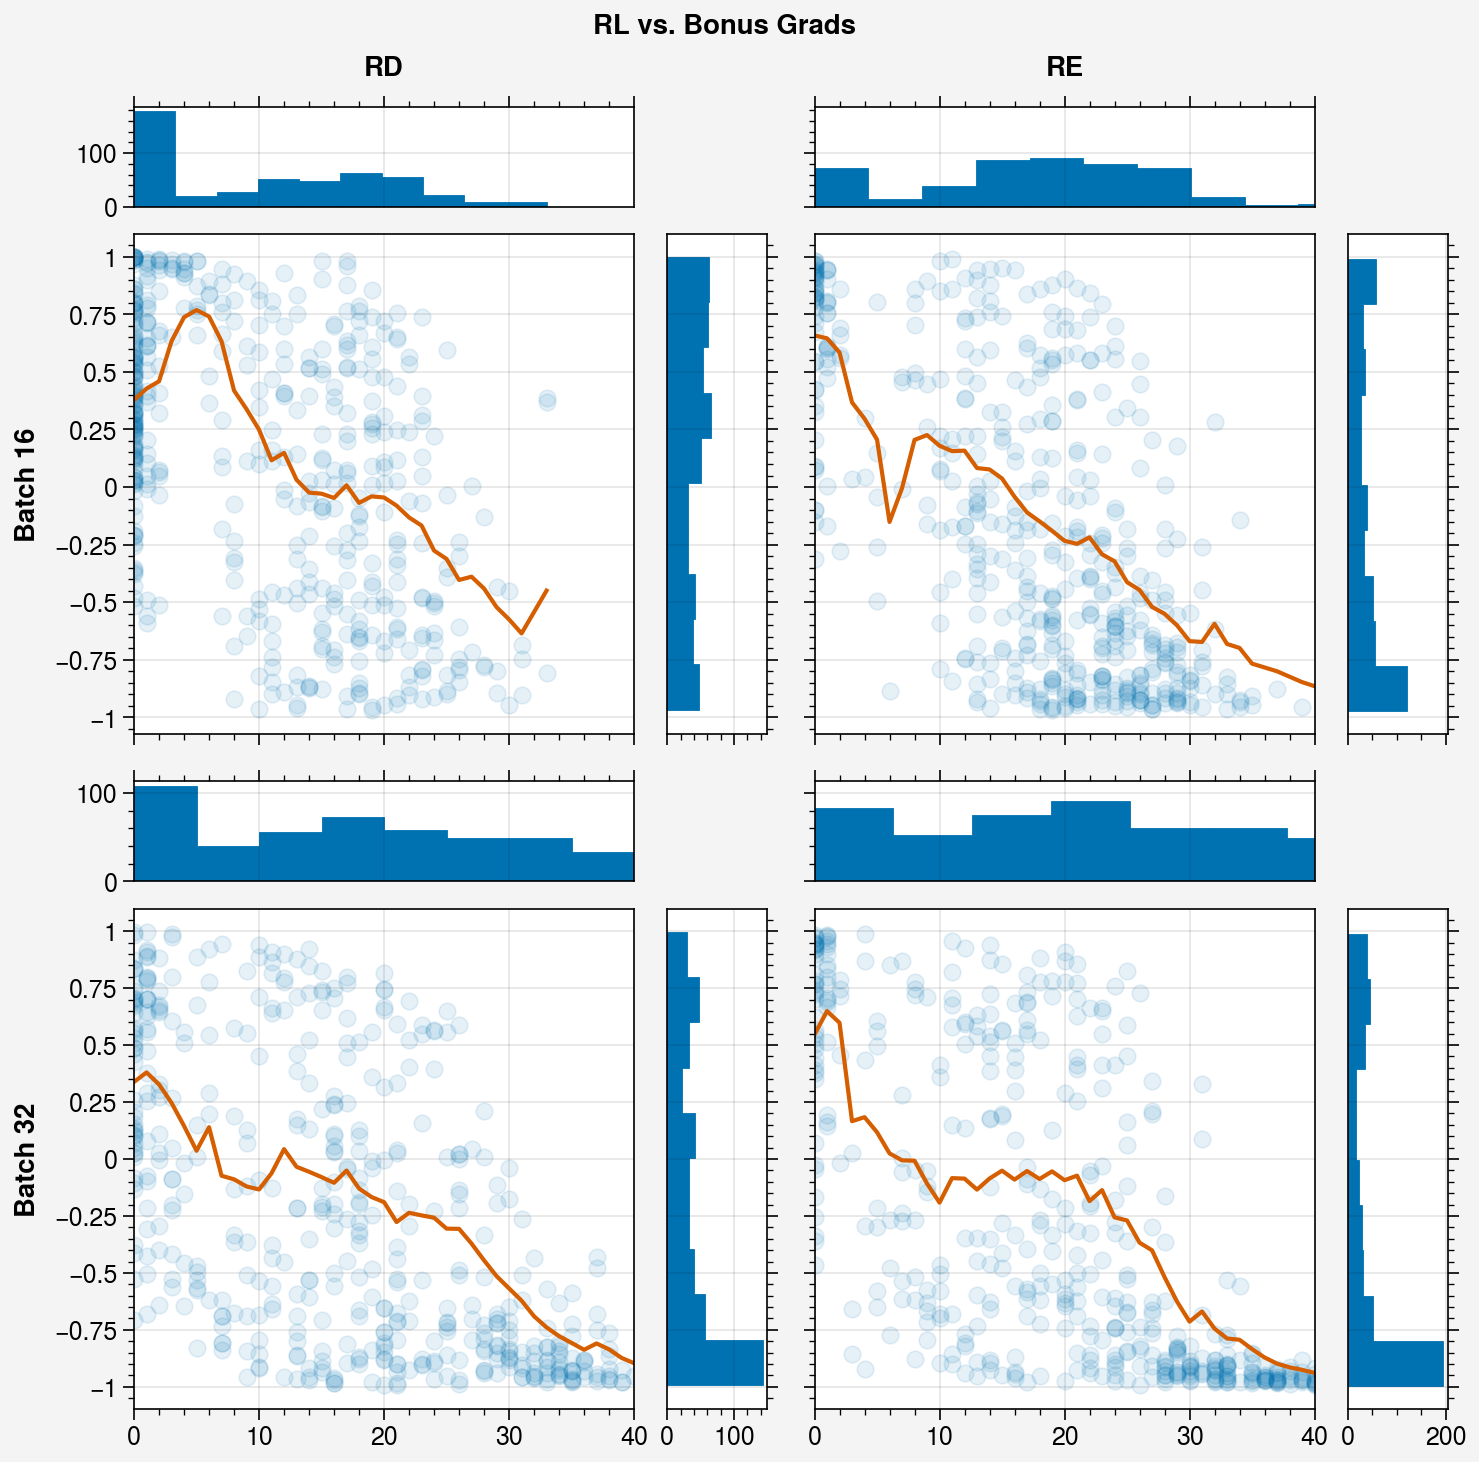

In [374]:
summary = pickle.load(open('data/grads/rew_aux_cs_summary_rlvsbonus', 'rb'))
all_cs_comb = summary['cs_comb']
all_rew = summary['rews']

aux_tasks = ['rewdistscale0015', 'rewexplore',]
aux_labels = ['RD', 'RE',]

fig, ax = pplt.subplots(nrows=2, ncols=2)

tax = ax.panel_axes('top')
rax = ax.panel_axes('right')

for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        
        cs = np.array(all_cs_comb[f'batch{batch}aux{aux}'])
        rews = np.array(all_rew[f'batch{batch}aux{aux}'])

        x_means = []
        y_means = []
        for r in np.unique(rews):
            x_means.append(r)
            y_means.append(cs[rews == r].mean())
        running_y_mean = pd.Series(y_means).ewm(alpha=0.3).mean()
        
        ax[i, j].scatter(all_rew[f'batch{batch}aux{aux}'], all_cs_comb[f'batch{batch}aux{aux}'], alpha=0.1)
        ax[i, j].plot(x_means, running_y_mean)
        
        tax[i, j].hist(rews)
        rax[i, j].histh(cs)
ax.format(toplabels=aux_labels, leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          xlim=[0, 40], suptitle='RL vs. Bonus Grads')

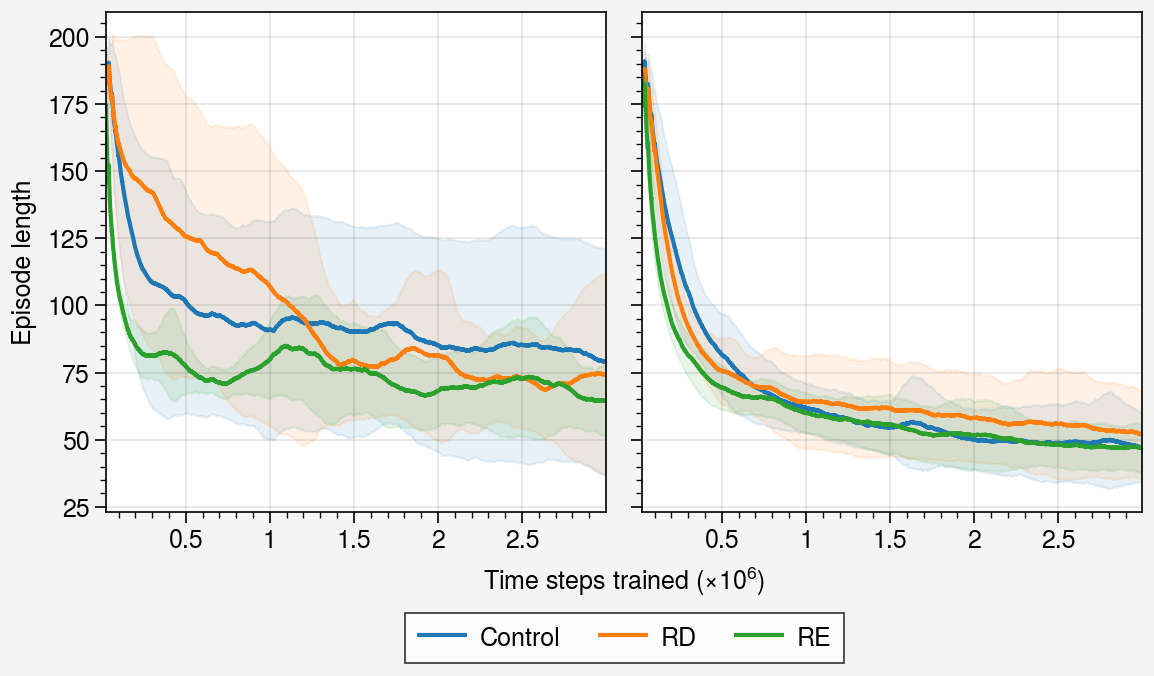

In [314]:
batch_sizes = [16, 32]
aux_names = ['none', 'rewdistscale0015', 'rewexplore']
aux_labels = ['Control', 'RD', 'RE']
fig, ax = pplt.subplots(ncols=len(batch_sizes))

for i, batch in enumerate(batch_sizes):
    lines = []
    for n, aux in enumerate(aux_names):
        exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        
        line = average_runs(exp_name, 'length', ax=ax[i], ignore_first=100, ewm=0.001, 
                            color=rgb_colors[n], cloud_by='std', div_x_by_mil=True)
        lines.append(line[0])
        
fig.legend(lines, labels=aux_labels, loc='b', ncol=3)

ax.format(ylabel='Episode length', xlabel=r'Time steps trained ($\times 10^6$)')



## Test Data Collection to ensure that we are selecting rewards correctly

In [224]:
ref_collect_batch = 256
collect_batch = 16
collect_processes = 4

aux_tasks = ['rewexplore', 'rewdist']

trials = range(10)
#Much fewer checkpoints to test since they mostly result in the same things anyways
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}

aux = 'rewdist'
batch = 32
chk = 900
trial = 0


exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
exp_name_t = f'{exp_name}_t{trial}'
env_kwargs = pickle.load(open(f'../trained_models/ppo/{exp_name}_env', 'rb'))

chk_path = Path('../trained_models/checkpoint/')/exp_name_t

model, obs_rms = torch.load(chk_path/f'{chks[0]}.pt')
agent, envs, storage = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs, num_steps=collect_batch,
                                        num_processes=collect_processes, ppo_epoch=1, take_optimizer_step=False, normalize=True,
                                        new_aux=False, log_dir='tmp')
obs = storage.obs[0].clone()
res = collect_batches_and_grads(agent, envs, storage, 50)

model, obs_rms = torch.load(chk_path/f'{chk}.pt')
obs = storage.obs[-1].clone()
envs.venv.obs_rms = obs_rms
agent, _, storage = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs, num_steps=collect_batch,
                                        num_processes=collect_processes, ppo_epoch=1, take_optimizer_step=False, normalize=True,
                                        make_env=False, obs=obs, new_aux=False, log_dir='tmp')


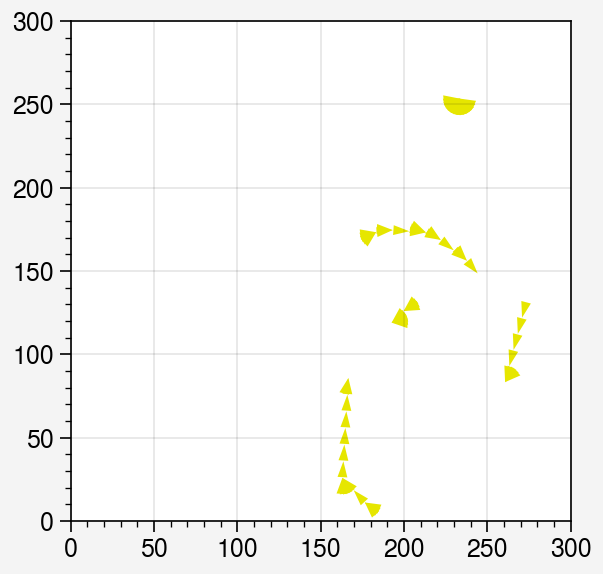

In [232]:
data, info = populate_rollouts(agent.actor_critic, envs, storage,
                               storage.num_steps, data_callback=nav_data_callback)

pos = np.stack(data['pos']).reshape(-1, 2)
angle = np.stack(data['angle']).reshape(-1)

fig, ax = pplt.subplots()
for i in range(len(pos)):
    draw_character(pos[i], angle[i], ax=ax)
    
ax.format(xlim=[0, 300], ylim=[0, 300])

storage.after_update()

In [217]:
res = collect_batches_and_auxrew_grads(agent, envs, storage, num_batches=20,
                                    data_callback=nav_data_callback, compute_pure_bonus=True)


In [233]:
bonus_rewards = []
for inf in info:
    bonus_rewards.append([i['bonus_reward'] for i in inf])
bonus_rewards = torch.tensor(bonus_rewards).reshape(
                    collect_batch, collect_processes, 1)



rew_pure_bonus = storage.rewards.clone()
rew_pure_goal = storage.rewards.clone()

where_bonus = (bonus_rewards != 0)

rew_pure_goal[where_bonus] = 0.
rew_pure_bonus[~where_bonus] = 0.

rew_pure_bonus

tensor([[[0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.3801],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.3161],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.3165],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000],
         [0.0000],
       

# Comparing average gradient magnitudes

In [377]:
all_res = pickle.load(open(f'data/grads/auxcat_100grads', 'rb'))


batch_sizes = [16, 32]
aux_tasks = ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
aux_labels = ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (E/N)']
auxiliary_truth_sizes = [[1], [1], [1, 1],  [1], [1]]
trials = range(10)
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}


aux_grad_norms = {}

for batch in batch_sizes:
    if batch not in aux_grad_norms: aux_grad_norms[batch] = {}
    for aux in aux_tasks:
        if aux not in aux_grad_norms[batch]: aux_grad_norms[batch][aux] = {}
        for trial in trials:
            if trial not in aux_grad_norms[batch][aux]: aux_grad_norms[batch][aux][trial] = {}
            chks = all_chks[batch]
            for chk in chks:
                
            
                res = all_res[batch][aux][trial][chk]

                aux_grad = all_res[batch][aux][trial][chk]['all_grads']['auxiliary']

                # Concatenate aux grads
                num_batches = len(aux_grad[0])
                gs = []
                for b in range(num_batches):
                    g = [aux_grad[layer][b].reshape(-1) for layer in layers]
                    gs.append(torch.concat(g))
                gs = torch.vstack(gs)

                aux_grad_norms[batch][aux][trial][chk] = gs.norm(dim=1)
                
pickle.dump(aux_grad_norms, open('data/grads/auxcat_grad_norms', 'wb'))

In [2]:
all_res = pickle.load(open(f'data/grads/aux_100grads', 'rb'))


batch_sizes = [16, 32]
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal']
trials = range(10)
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}


aux_grad_norms = {}

for batch in batch_sizes:
    if batch not in aux_grad_norms: aux_grad_norms[batch] = {}
    for aux in aux_tasks:
        if aux not in aux_grad_norms[batch]: aux_grad_norms[batch][aux] = {}
        for trial in trials:
            if trial not in aux_grad_norms[batch][aux]: aux_grad_norms[batch][aux][trial] = {}
            chks = all_chks[batch]
            for chk in chks:
                
            
                res = all_res[batch][aux][trial][chk]

                aux_grad = all_res[batch][aux][trial][chk]['all_grads']['auxiliary']

                # Concatenate aux grads
                num_batches = len(aux_grad[0])
                layers = range(len(aux_grad))
                gs = []
                for b in range(num_batches):
                    g = [aux_grad[layer][b].reshape(-1) for layer in layers]
                    gs.append(torch.concat(g))
                gs = torch.vstack(gs)

                aux_grad_norms[batch][aux][trial][chk] = gs.norm(dim=1)
                
pickle.dump(aux_grad_norms, open('data/grads/aux_grad_norms', 'wb'))

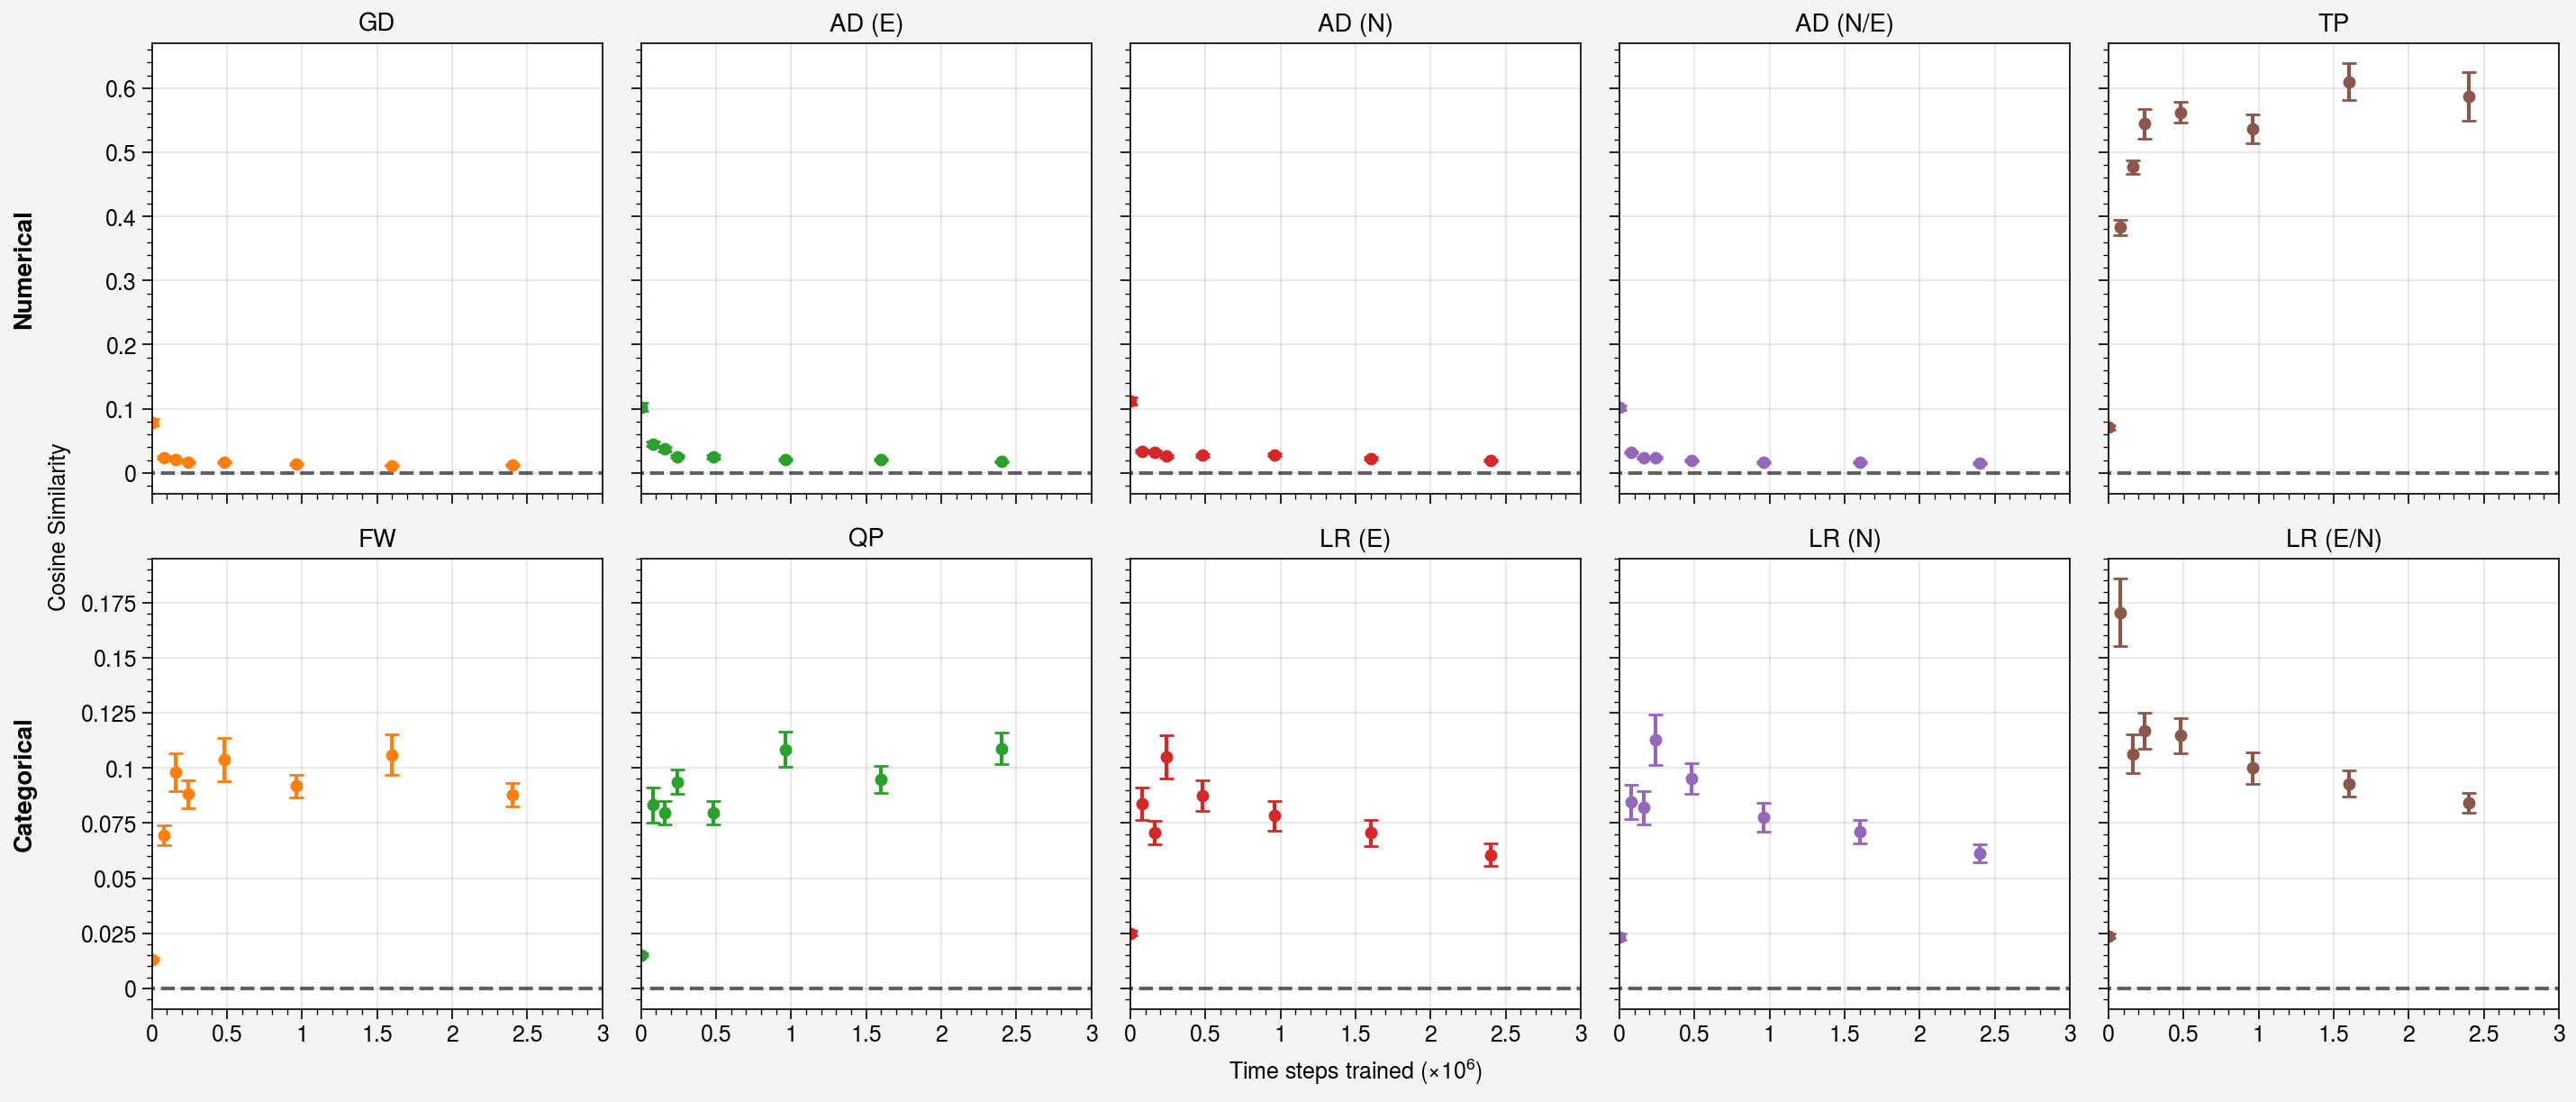

In [9]:
all_cs_means = {
    'num': pickle.load(open('data/grads/aux_grad_norms', 'rb')),
    'cat': pickle.load(open('data/grads/auxcat_grad_norms', 'rb'))
}
all_aux_tasks = {
    'num': ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal'],
    'cat': ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
}
all_aux_labels = {
    'num': ['GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP'],
    'cat': ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (E/N)']
}

trials = range(10)
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}

batch = 16

fig, ax = pplt.subplots(nrows=2, ncols=5)


for i, typ in enumerate(['num', 'cat']):
    cs_means = all_cs_means[typ]
    aux_tasks = all_aux_tasks[typ]
    
    for j, aux in enumerate(aux_tasks):
        chk_means = []
        errors = []
        xs = []

        chks = all_chks[batch]

        for chk in chks:
            xs.append(chk * batch * 100 / 1000000)
            cos_sims = []
            for trial in trials:
                cs = cs_means[batch][aux][trial][chk]
                cos_sims.append(cs.numpy())
            cs = np.array(cos_sims).reshape(-1)
            mean = np.mean(cs)
            interval = stats.t.interval(alpha=0.95, df=len(cs)-1, 
                             loc=mean, scale=stats.sem(cs))

            errors.append(interval[1] - mean)
            chk_means.append(mean)


        ax[i, j].errorbar(xs, chk_means, errors, linestyle='',
                          marker='o', markersize=4, c=rgb_colors[j+1])

        ax[i, j].plot([-1, 3], [0, 0], '--k', alpha=0.6)

ax.format(xlim=[0, 3], ylabel='Cosine Similarity',
          xlabel=r'Time steps trained ($\times 10^6$)',
          leftlabels=['Numerical', 'Categorical'],
          title=all_aux_labels['num'] + all_aux_labels['cat'])
